In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from skimage import io

2023-04-02 14:54:01.784424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '/Users/xeniat/Desktop/AI for Biomed Applications/data-science-bowl-2018/stage1_train/'
TEST_PATH = '/Users/xeniat/Desktop/AI for Biomed Applications/data-science-bowl-2018/stage1_test/'
FINAL_TEST_PATH = '/Users/xeniat/Desktop/AI for Biomed Applications/data-science-bowl-2018/stage2_test_final/'

#TRAIN_PATH = 'data/stage1_train/'
#TEST_PATH = 'data/stage1_test/'
#FINAL_TEST_PATH = 'data/stage2_test_final/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
os.getcwd()

'/Users/xeniat/Desktop/AI for Biomed Applications'

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]
# final_test_ids = next(os.walk(FINAL_TEST_PATH))[1]

In [5]:
len(train_ids)

670

### Get the data
- Downsample both the training and test images to reduce computations
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings

In [6]:
# Get and resize train images and masks
IMAGES = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
MASKS = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

Getting and resizing train images and masks ... 


/var/folders/rh/1yz9zqmn39x6hqx229j86ngm0000gn/T/ipykernel_692/3327968468.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MASKS = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [7]:
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    IMAGES[n] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        
        #Overlay individual masks to create a final mask for corresponding image
        mask = np.maximum(mask, mask_)
    
    #Append mask to numpy array for train dataset
    MASKS[n] = mask

# # Get and resize test images
# X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
# print('Getting and resizing test images ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path = TEST_PATH + id_
    
#     #Read images iteratively
#     img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
#     #Get test size
#     sizes_test.append([img.shape[0], img.shape[1]])
    
#     #Resize image to match training data
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
#     #Append image to numpy array for test dataset
#     X_test[n] = img

print('Done!')

  0%|                                                   | 0/670 [00:00<?, ?it/s]/var/folders/rh/1yz9zqmn39x6hqx229j86ngm0000gn/T/ipykernel_692/543300970.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|█████████████████████████████████████████| 670/670 [05:02<00:00,  2.21it/s]

Done!


In [8]:
# Split the data into train, test. (10% validation will be later)
from sklearn.model_selection import train_test_split

# X is our feature matrix and y is our target vector
# test_size specifies the percentage of the data to use for testing
# random_state is a seed for the random number generator, to ensure reproducibility
X_train, X_test, Y_train, Y_test = train_test_split(IMAGES, MASKS, test_size=0.2, random_state=42)

In [9]:
len(X_train)

536

In [13]:
536*0.1

53.6

In [10]:
len(X_test)

134

### Visualize imported data

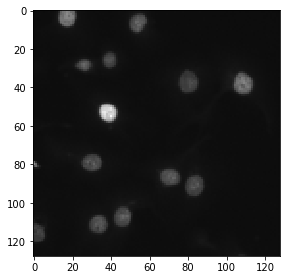

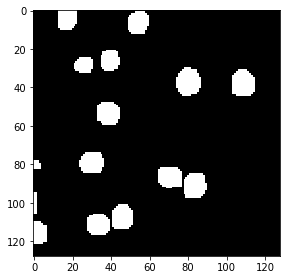

In [22]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(IMAGES[ix])
plt.show()
imshow(np.squeeze(MASKS[ix]))
plt.show()

## Build and train our neural network

Next we build our U-Net model, loosely based on U-Net: Convolutional Networks for Biomedical Image Segmentation (https://arxiv.org/pdf/1505.04597.pdf) and very similar to this repo (https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

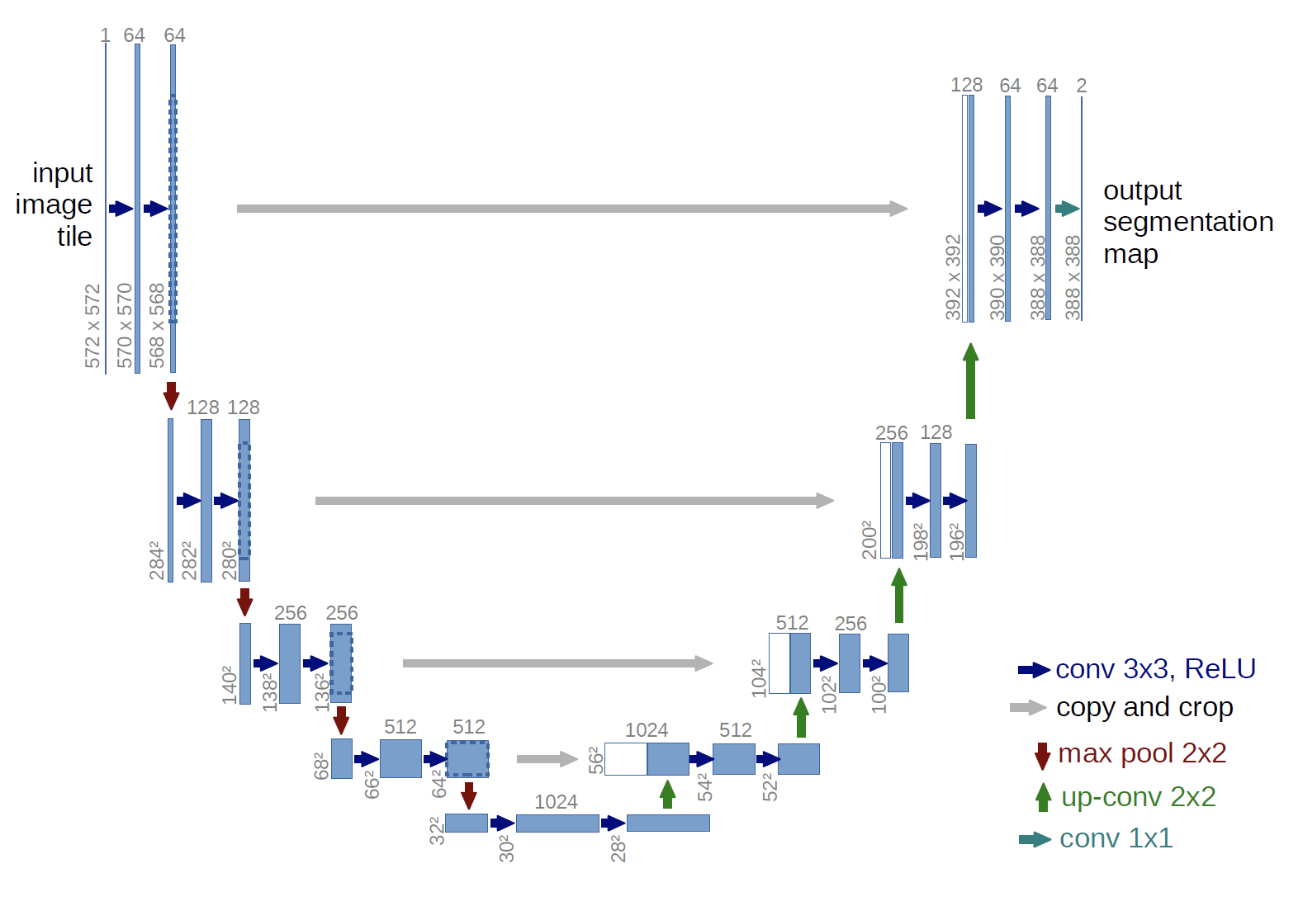

This is the implementation of the U-Net architecture, which is a popular convolutional neural network architecture used for image segmentation tasks.

The network takes as input an image with dimensions IMG_HEIGHT x IMG_WIDTH x IMG_CHANNELS. The input is first normalized using a Lambda layer which scales pixel values to [0,1] range.

The network consists of a contracting path (encoder) and an expanding path (decoder) with skip connections between corresponding layers.

The contracting path has four max-pooling layers, which halves the dimensions of the feature maps at each step. It starts with two convolutional layers (Conv2D) with 32 filters and 3x3 kernel size. Batch normalization is applied after each convolutional layer, followed by a dropout layer with a rate of 0.1. The same set of convolutional and normalization layers are repeated twice for the subsequent layers with a doubling number of filters at each layer.

The expanding path has four transposed convolutional layers (Conv2DTranspose), which doubles the dimensions of the feature maps at each step. The transposed convolutional layer is followed by concatenation of the output of the corresponding layer in the contracting path and upsampling the feature maps. Then, two convolutional layers (Conv2D) with 3x3 kernel size are applied, followed by batch normalization and a dropout layer with a rate of 0.1 or 0.2, depending on the layer. The number of filters in the convolutional layers decreases by a factor of two at each step. Finally, the last layer has a single filter with 1x1 kernel size and sigmoid activation to produce the segmentation mask.

Overall, the U-Net architecture allows for efficient feature extraction and semantic segmentation by utilizing both high and low-level features, as well as the skip connections to better preserve the spatial information during upsampling.

In [70]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [27]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.01],
    'dropout': [0.1, 0.2],
    'optimizer': ['adam', 'sgd']
}

Here, we defined a parameter grid with four hyperparameters: batch_size, learning_rate, dropout, and optimizer. We will try two values for each hyperparameter, giving us a total of 2 x 2 x 2 x 2 = 16 possible combinations of hyperparameters. We can then use this parameter grid to perform a grid search with the GridSearchCV class:

In [71]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 32  896         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

                                                                                                  
 concatenate_9 (Concatenate)    (None, 16, 16, 384)  0           ['conv2d_transpose_4[0][0]',     
                                                                  'batch_normalization_48[0][0]'] 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 16, 16, 256)  884992      ['concatenate_9[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_27 (Dropout)           (None, 16, 16, 256)  0           ['batch_normalization_51[0][0]'] 
          

In [56]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1) # An change to 5 or 10
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9576
Epoch 1: val_loss improved from inf to 4.74893, saving model to model_unet_checkpoint.h5
31/31 [==============================] - 77s 2s/step - loss: 0.1111 - accuracy: 0.9576 - val_loss: 4.7489 - val_accuracy: 0.8420
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9634
Epoch 2: val_loss improved from 4.74893 to 0.12174, saving model to model_unet_checkpoint.h5
31/31 [==============================] - 88s 3s/step - loss: 0.0951 - accuracy: 0.9634 - val_loss: 0.1217 - val_accuracy: 0.9567
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9561
Epoch 3: val_loss did not improve from 0.12174
31/31 [==============================] - 78s 3s/step - loss: 0.1153 - accuracy: 0.9561 - val_loss: 0.5529 - val_accuracy: 0.8320
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9623
Epoch 4:

31/31 [==============================] - 79s 3s/step - loss: 0.0773 - accuracy: 0.9699 - val_loss: 0.0712 - val_accuracy: 0.9715
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9704
Epoch 30: val_loss did not improve from 0.07049
31/31 [==============================] - 79s 3s/step - loss: 0.0762 - accuracy: 0.9704 - val_loss: 0.0721 - val_accuracy: 0.9720
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9707
Epoch 31: val_loss did not improve from 0.07049
31/31 [==============================] - 80s 3s/step - loss: 0.0748 - accuracy: 0.9707 - val_loss: 0.0742 - val_accuracy: 0.9708
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9697
Epoch 32: val_loss did not improve from 0.07049
31/31 [==============================] - 76s 2s/step - loss: 0.0785 - accuracy: 0.9697 - val_loss: 0.0720 - val_accuracy: 0.9717
Epoch 33/50
31/31 [==============================] - ET

## Vusialize training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


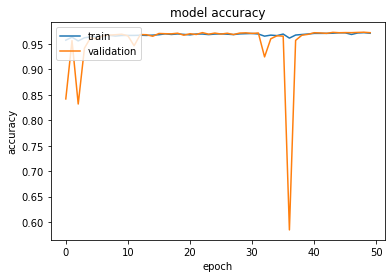

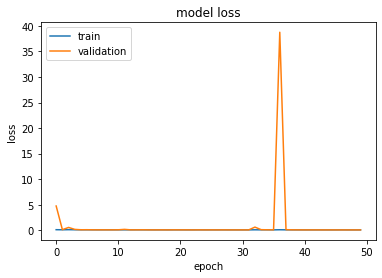

In [57]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

validation fluctuates at first then stabilizes as expected from a model like Unet

### Good Fit Learning Curves
A good fit is the goal of the learning algorithm and exists between an overfit and underfit model.

A good fit is identified by a training and validation loss that decreases to a point of stability with a minimal gap between the two final loss values.

The loss of the model will almost always be lower on the training dataset than the validation dataset. This means that we should expect some gap between the train and validation loss learning curves. This gap is referred to as the “generalization gap.”

A plot of learning curves shows a good fit if:

The plot of training loss decreases to a point of stability.
The plot of validation loss decreases to a point of stability and has a small gap with the training loss.
Continued training of a good fit will likely lead to an overfit.

The example plot below demonstrates a case of a good fit.

### Make predictions

In [58]:
# Predict on test
model = load_model('model_unet_checkpoint.h5')
preds_test = model.predict(X_test, verbose=0)

In [59]:
len(preds_test)

134

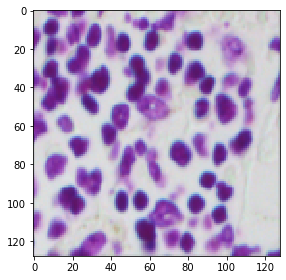

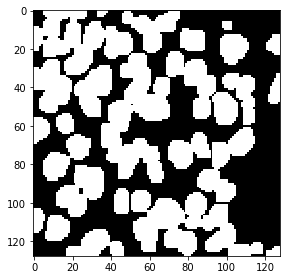

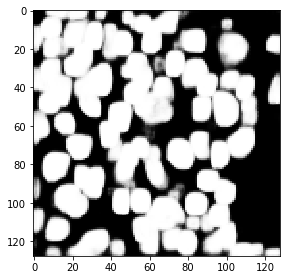

In [60]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(Y_test[ix]))
plt.show()
imshow(np.squeeze(preds_test[ix]))
plt.show()

The U-Net model is typically used for image segmentation tasks, where the goal is to classify each pixel of an input image into one of several classes. Here are some common ways to evaluate the performance of a U-Net model:

1. Intersection over Union (IoU): IoU is a commonly used metric for evaluating image segmentation models. It measures the overlap between the predicted segmentation and the ground truth segmentation. A higher IoU score indicates better segmentation accuracy.

2. Dice coefficient: The Dice coefficient is another commonly used metric for evaluating image segmentation models. It measures the overlap between the predicted segmentation and the ground truth segmentation, but is more sensitive to the presence of false positives and false negatives.

2. Precision, recall, and F1-score: Precision measures the proportion of true positives among all positive predictions, recall measures the proportion of true positives among all actual positive examples, and F1-score is the harmonic mean of precision and recall. These metrics can be used to evaluate the performance of a U-Net model on a per-class basis.

3. Visual inspection: It is also important to visually inspect the model's predictions to ensure that it is correctly segmenting the images. We can overlay the predicted segmentation onto the original image and compare it with the ground truth segmentation to identify areas where the model is making mistakes.

4. Cross-validation: To get a more reliable estimate of the model's performance, We can use cross-validation. This involves splitting the dataset into multiple folds, training the model on each fold while using the remaining folds for validation, and then averaging the performance metrics across all folds.

Overall, evaluating the performance of a U-Net model requires a combination of quantitative metrics and qualitative visual inspection.

In [61]:
def iou_score(y_true, y_pred):
    """
    Calculate the Intersection over Union (IoU) score for a U-Net model.
    Args:
        y_true (np.ndarray): The ground truth segmentation.
        y_pred (np.ndarray): The predicted segmentation.
    Returns:
        float: The IoU score.
    """
    # Flatten the arrays
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate the intersection and union
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection

    # Calculate the IoU score
    iou = intersection / union

    return iou

In [62]:
IOU = iou_score(Y_test, preds_test)
print("IOU score:", IOU)

IOU score: 0.8504424804664632


In [63]:
# Dice coeff

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice

In [64]:
dice = dice_coef(Y_test, preds_test)
print("Dice coefficient:", dice.numpy())

Dice coefficient: 0.91917753


In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_flat = preds_test.reshape(-1)

# Convert predictions to binary values
y_pred_flat_binary = y_pred_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_flat_binary)
recall = recall_score(y_true_flat, y_pred_flat_binary)
f1 = f1_score(y_true_flat, y_pred_flat_binary)

# Print the metrics for the test set
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9393593811146588
Recall: 0.9456281723098982
F1-score: 0.9424833528389277


## Hyperparameters tuning

Some examples of hyperparameters that can be tuned for U-Net include learning rate, batch size, number of filters, number of layers, dropout rate, and activation function.

In detail: 

- Learning rate: The learning rate controls the step size of the optimizer during training. A higher learning rate can speed up training, but it can also cause the model to converge to a suboptimal solution.

- Optimizer: The optimizer determines how the model weights are updated during training. The adam optimizer is a popular choice for U-Net models, but we can also try other optimizers like SGD or RMSprop.

- Loss function: The loss function determines how the model performance is evaluated during training. The binary_crossentropy loss is a common choice for binary segmentation tasks, but we can also try other loss functions like dice_loss or jaccard_loss.

- Number of filters: The number of filters controls the depth of the U-Net model. A larger number of filters can increase the model capacity, but it can also lead to overfitting.

- Dropout rate: Dropout is a regularization technique that can prevent overfitting by randomly dropping out some units during training. The dropout rate controls the probability of dropping out each unit.

- Activation function: The activation function determines the nonlinearity of the U-Net model. The relu activation function is commonly used in convolutional layers, but we can also try other activation functions like sigmoid or tanh.

In general, it is a good idea to start by tuning one hyperparameter at a time, while holding the others constant. This can help us understand the effect of each hyperparameter on the performance of the model, and can help us identify the most important hyperparameters to tune. Once we have identified the most important hyperparameters, we can then try tuning them in combination to find the best set of hyperparameters.

That being said, tuning hyperparameters one at a time can be time-consuming, especially if we have many hyperparameters to tune. In some cases, it may be more efficient to use techniques such as random search or Bayesian optimization (tried, had errors) to search the hyperparameter space more efficiently. These techniques allow us to search the hyperparameter space more effectively by sampling hyperparameters from a distribution, rather than exhaustively searching every possible combination. This can help us find good hyperparameters more quickly, and can allow us to tune multiple hyperparameters simultaneously.

______________________________________________________________________________________________________________________

The default learning rate for the Adam optimizer in TensorFlow is 0.001
For nuclei segmentation using U-Net, a good starting point for learning rate tuning could be to use a range of values between 1e-5 and 1e-3. This range is commonly used for image segmentation tasks with U-Net architectures.

We can start by trying different learning rates in this range and monitor the validation loss during training. If the loss is not decreasing or is fluctuating wildly, it may be a sign that the learning rate is too high. On the other hand, if the loss is decreasing very slowly or the training is unstable, it may be a sign that the learning rate is too low.

One useful approach for learning rate tuning is to use a learning rate scheduler that reduces the learning rate during training if the validation loss has stopped decreasing. This can help the model converge to a good solution by allowing it to explore different parts of the loss surface.

Another approach is to use a grid search or random search to try different combinations of hyperparameters, including the learning rate, and choose the combination that gives the best performance on a validation set. This approach can be time-consuming, but can be effective for finding the optimal hyperparameters.

In [99]:
# UNET with lower learning rate 
# Define the optimizer with the desired learning rate
optimizer = Adam(lr=0.0001)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 256)  884992      ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_5 (Dropout)            (None, 16, 16, 256)  0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 256)  590080      ['dropout_5[0][0]']              
          

In [100]:
# Fit model
#earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint('unet_lr_1.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9758
Epoch 1: val_loss improved from inf to 0.06344, saving model to unet_lr_1.h5
31/31 [==============================] - 72s 2s/step - loss: 0.0610 - accuracy: 0.9758 - val_loss: 0.0634 - val_accuracy: 0.9743
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9766
Epoch 2: val_loss did not improve from 0.06344
31/31 [==============================] - 67s 2s/step - loss: 0.0590 - accuracy: 0.9766 - val_loss: 0.0642 - val_accuracy: 0.9740
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9769
Epoch 3: val_loss did not improve from 0.06344
31/31 [==============================] - 74s 2s/step - loss: 0.0582 - accuracy: 0.9769 - val_loss: 0.0636 - val_accuracy: 0.9742
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9771
Epoch 4: val_loss did not improve from 0.06344
31/31 [============

Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9783
Epoch 31: val_loss did not improve from 0.06315
31/31 [==============================] - 73s 2s/step - loss: 0.0539 - accuracy: 0.9783 - val_loss: 0.0653 - val_accuracy: 0.9740
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9781
Epoch 32: val_loss did not improve from 0.06315
31/31 [==============================] - 74s 2s/step - loss: 0.0542 - accuracy: 0.9781 - val_loss: 0.0640 - val_accuracy: 0.9740
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9781
Epoch 33: val_loss did not improve from 0.06315
31/31 [==============================] - 73s 2s/step - loss: 0.0544 - accuracy: 0.9781 - val_loss: 0.0828 - val_accuracy: 0.9680
Epoch 34/50
31/31 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9783
Epoch 34: val_loss did not improve from 0.06315
31/31 [==============================] - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


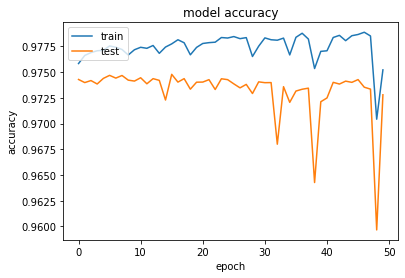

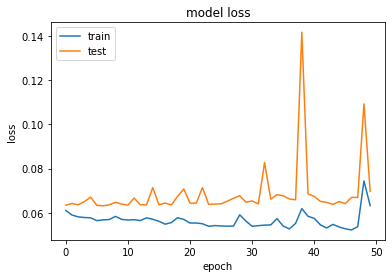

In [101]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Unrepresentative Train Dataset
An unrepresentative training dataset means that the training dataset does not provide sufficient information to learn the problem, relative to the validation dataset used to evaluate it.

This may occur if the training dataset has too few examples as compared to the validation dataset.

This situation can be identified by a learning curve for training loss that shows improvement and similarly a learning curve for validation loss that shows improvement, but a large gap remains between both curves.

Alterating the learning rate does this (unstable behaviour), so we went with 0.001 (default). Too low learning rate means the model is not spending enough time on each sweep of the dataset so it's not picking up the details from the training images. Hence the random "hit or miss" behaviour??

In [102]:
# Predict on test
model_1 = load_model('unet_lr_1.h5')
preds_test_1 = model_1.predict(X_test, verbose=0)

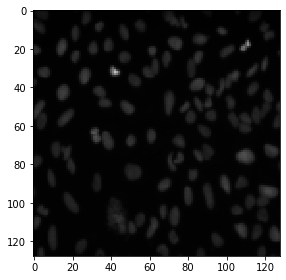

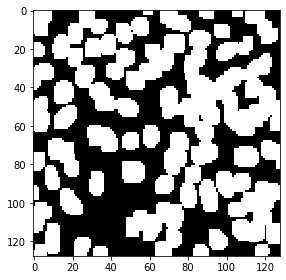

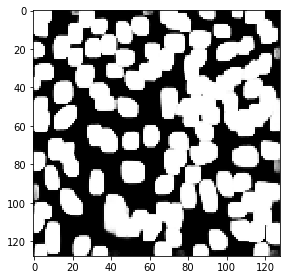

In [103]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test_1))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(Y_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_1[ix]))
plt.show()

In [104]:
IOU = iou_score(Y_test, preds_test_1)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_1)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_1.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8573638742388677

Dice coefficient: 0.9232051

Precision: 0.9462846606816643
Recall: 0.9406336335016214
F1-score: 0.9434506851173518


In [105]:
# UNET with higher learning rate 
# Define the optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.01)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 256)  884992      ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_5 (Dropout)            (None, 16, 16, 256)  0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 256)  590080      ['dropout_5[0][0]']              
          

In [106]:
# Fit model
# earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint('unet_lr_2.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9637
Epoch 1: val_loss improved from inf to 0.33204, saving model to unet_lr_2.h5
31/31 [==============================] - 74s 2s/step - loss: 0.0973 - accuracy: 0.9637 - val_loss: 0.3320 - val_accuracy: 0.8866
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9664
Epoch 2: val_loss improved from 0.33204 to 0.24076, saving model to unet_lr_2.h5
31/31 [==============================] - 73s 2s/step - loss: 0.0898 - accuracy: 0.9664 - val_loss: 0.2408 - val_accuracy: 0.9430
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9676
Epoch 3: val_loss improved from 0.24076 to 0.08722, saving model to unet_lr_2.h5
31/31 [==============================] - 75s 2s/step - loss: 0.0856 - accuracy: 0.9676 - val_loss: 0.0872 - val_accuracy: 0.9671
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.968

31/31 [==============================] - 66s 2s/step - loss: 0.0809 - accuracy: 0.9687 - val_loss: 0.0764 - val_accuracy: 0.9705
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9714
Epoch 31: val_loss did not improve from 0.07287
31/31 [==============================] - 66s 2s/step - loss: 0.0748 - accuracy: 0.9714 - val_loss: 0.0751 - val_accuracy: 0.9708
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9718
Epoch 32: val_loss improved from 0.07287 to 0.07138, saving model to unet_lr_2.h5
31/31 [==============================] - 71s 2s/step - loss: 0.0723 - accuracy: 0.9718 - val_loss: 0.0714 - val_accuracy: 0.9720
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9716
Epoch 33: val_loss improved from 0.07138 to 0.06803, saving model to unet_lr_2.h5
31/31 [==============================] - 69s 2s/step - loss: 0.0736 - accuracy: 0.9716 - val_loss: 0.0680 - val_accu

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


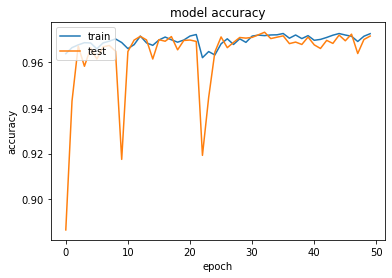

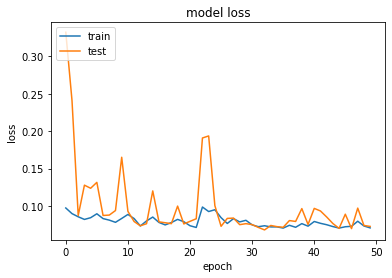

In [107]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
# Predict on test
model_2 = load_model('unet_lr_2.h5')
preds_test_2 = model_2.predict(X_test, verbose=0)

In [110]:
IOU = iou_score(Y_test, preds_test_2)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_2)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_2.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.844028460576329

Dice coefficient: 0.9154182

Precision: 0.933073278632172
Recall: 0.9500089610885862
F1-score: 0.9414649635103763


### Batch size 

In [111]:
optimizer = Adam(lr=0.001)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 256)  884992      ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_5 (Dropout)            (None, 16, 16, 256)  0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 256)  590080      ['dropout_5[0][0]']              
          

In [112]:
# Fit model
# earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint('unet_bs_1.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=10, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9733
Epoch 1: val_loss improved from inf to 0.06677, saving model to unet_bs_1.h5
49/49 [==============================] - 74s 1s/step - loss: 0.0676 - accuracy: 0.9733 - val_loss: 0.0668 - val_accuracy: 0.9728
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9732
Epoch 2: val_loss improved from 0.06677 to 0.06521, saving model to unet_bs_1.h5
49/49 [==============================] - 70s 1s/step - loss: 0.0678 - accuracy: 0.9732 - val_loss: 0.0652 - val_accuracy: 0.9736
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9738
Epoch 3: val_loss did not improve from 0.06521
49/49 [==============================] - 72s 1s/step - loss: 0.0666 - accuracy: 0.9738 - val_loss: 0.0656 - val_accuracy: 0.9733
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9739
Epoch 4: val_loss did not improv

Epoch 30/50
49/49 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9756
Epoch 30: val_loss did not improve from 0.06308
49/49 [==============================] - 77s 2s/step - loss: 0.0611 - accuracy: 0.9756 - val_loss: 0.0643 - val_accuracy: 0.9737
Epoch 31/50
49/49 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9754
Epoch 31: val_loss did not improve from 0.06308
49/49 [==============================] - 80s 2s/step - loss: 0.0619 - accuracy: 0.9754 - val_loss: 0.0638 - val_accuracy: 0.9741
Epoch 32/50
49/49 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9759
Epoch 32: val_loss did not improve from 0.06308
49/49 [==============================] - 80s 2s/step - loss: 0.0610 - accuracy: 0.9759 - val_loss: 0.0638 - val_accuracy: 0.9740
Epoch 33/50
49/49 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9757
Epoch 33: val_loss did not improve from 0.06308
49/49 [==============================] - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


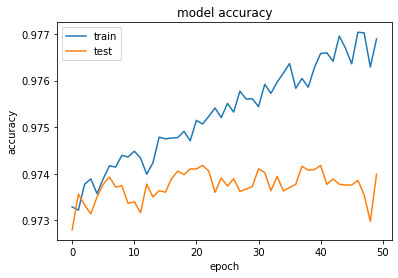

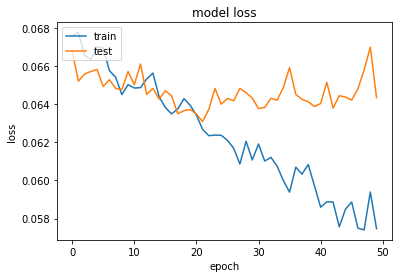

In [113]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [114]:
# Predict on test
model_1_bs = load_model('unet_bs_1.h5')
preds_test_1_bs = model_1_bs.predict(X_test, verbose=0)

In [115]:
IOU = iou_score(Y_test, preds_test_1_bs)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_1_bs)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_1_bs.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8594314869529629

Dice coefficient: 0.9244026

Precision: 0.9384975036318399
Recall: 0.9502777937461746
F1-score: 0.9443509118586997


In [116]:
# Fit model
# earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint('unet_bs_2.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=4, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
121/121 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9741
Epoch 1: val_loss improved from inf to 0.06534, saving model to unet_bs_2.h5
121/121 [==============================] - 81s 667ms/step - loss: 0.0656 - accuracy: 0.9741 - val_loss: 0.0653 - val_accuracy: 0.9738
Epoch 2/50
121/121 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9747
Epoch 2: val_loss did not improve from 0.06534
121/121 [==============================] - 81s 667ms/step - loss: 0.0640 - accuracy: 0.9747 - val_loss: 0.0665 - val_accuracy: 0.9734
Epoch 3/50
121/121 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9742
Epoch 3: val_loss improved from 0.06534 to 0.06527, saving model to unet_bs_2.h5
121/121 [==============================] - 84s 695ms/step - loss: 0.0651 - accuracy: 0.9742 - val_loss: 0.0653 - val_accuracy: 0.9734
Epoch 4/50
121/121 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9748
Epoch 4: 

Epoch 30/50
121/121 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9770
Epoch 30: val_loss did not improve from 0.06439
121/121 [==============================] - 100s 825ms/step - loss: 0.0575 - accuracy: 0.9770 - val_loss: 0.0661 - val_accuracy: 0.9735
Epoch 31/50
121/121 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9759
Epoch 31: val_loss did not improve from 0.06439
121/121 [==============================] - 102s 846ms/step - loss: 0.0599 - accuracy: 0.9759 - val_loss: 0.0733 - val_accuracy: 0.9713
Epoch 32/50
121/121 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9764
Epoch 32: val_loss did not improve from 0.06439
121/121 [==============================] - 103s 853ms/step - loss: 0.0586 - accuracy: 0.9764 - val_loss: 0.0662 - val_accuracy: 0.9734
Epoch 33/50
121/121 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9772
Epoch 33: val_loss did not improve from 0.06439
121/121 [======

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


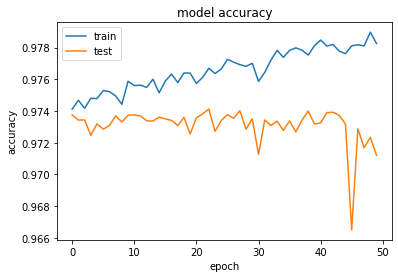

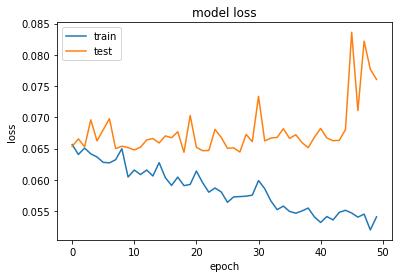

In [117]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [118]:
# Predict on test
model_1_bs = load_model('unet_bs_2.h5')
preds_test_1_bs = model_1_bs.predict(X_test, verbose=0)

In [119]:
IOU = iou_score(Y_test, preds_test_1_bs)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_1_bs)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_1_bs.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.856780742317179

Dice coefficient: 0.92286664

Precision: 0.943394820954548
Recall: 0.9421857616756221
F1-score: 0.942789903682662


In [191]:
# batch size 32 - with early stopping
#earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint('unet_bs_32.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8500
Epoch 1: val_loss improved from inf to 1.67874, saving model to unet_bs_32.h5
16/16 [==============================] - 78s 4s/step - loss: 0.3833 - accuracy: 0.8500 - val_loss: 1.6787 - val_accuracy: 0.2915
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.9396
Epoch 2: val_loss improved from 1.67874 to 0.84096, saving model to unet_bs_32.h5
16/16 [==============================] - 66s 4s/step - loss: 0.2057 - accuracy: 0.9396 - val_loss: 0.8410 - val_accuracy: 0.6550
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9465
Epoch 3: val_loss did not improve from 0.84096
16/16 [==============================] - 64s 4s/step - loss: 0.1788 - accuracy: 0.9465 - val_loss: 1.1448 - val_accuracy: 0.7334
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.9543
Epoch 4: val_loss did not impr

Epoch 30/50
16/16 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9618
Epoch 30: val_loss did not improve from 0.27709
16/16 [==============================] - 67s 4s/step - loss: 0.1064 - accuracy: 0.9618 - val_loss: 0.3278 - val_accuracy: 0.8719
Epoch 31/50
16/16 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9645
Epoch 31: val_loss did not improve from 0.27709
16/16 [==============================] - 67s 4s/step - loss: 0.0992 - accuracy: 0.9645 - val_loss: 0.3379 - val_accuracy: 0.8730
Epoch 32/50
16/16 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9647
Epoch 32: val_loss did not improve from 0.27709
16/16 [==============================] - 76s 5s/step - loss: 0.0977 - accuracy: 0.9647 - val_loss: 0.3504 - val_accuracy: 0.8750
Epoch 33/50
16/16 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9639
Epoch 33: val_loss did not improve from 0.27709
16/16 [==============================] - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


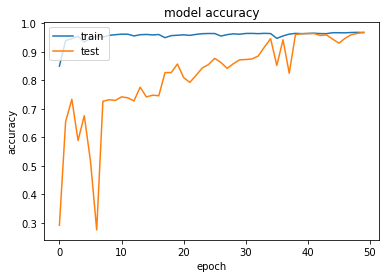

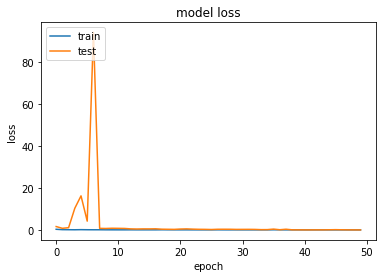

In [192]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [193]:
# Predict on test
model_bs_32 = load_model('unet_bs_32.h5')
preds_test_bs_32 = model_bs_32.predict(X_test, verbose=0)

In [194]:
IOU = iou_score(Y_test, preds_test_bs_32)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_bs_32)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_bs_32.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8263590248682182

Dice coefficient: 0.90492475

Precision: 0.9475986713832099
Recall: 0.920339304010848
F1-score: 0.9337700857208043


In [196]:
# batch size 8
checkpointer = ModelCheckpoint('unet_bs_8.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9619
Epoch 1: val_loss improved from inf to 0.08303, saving model to unet_bs_8.h5
61/61 [==============================] - 70s 1s/step - loss: 0.1046 - accuracy: 0.9619 - val_loss: 0.0830 - val_accuracy: 0.9688
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9498
Epoch 2: val_loss did not improve from 0.08303
61/61 [==============================] - 72s 1s/step - loss: 0.1344 - accuracy: 0.9498 - val_loss: 0.1998 - val_accuracy: 0.9465
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9581
Epoch 3: val_loss did not improve from 0.08303
61/61 [==============================] - 70s 1s/step - loss: 0.1122 - accuracy: 0.9581 - val_loss: 0.0993 - val_accuracy: 0.9628
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9622
Epoch 4: val_loss did not improve from 0.08303
61/61 [============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


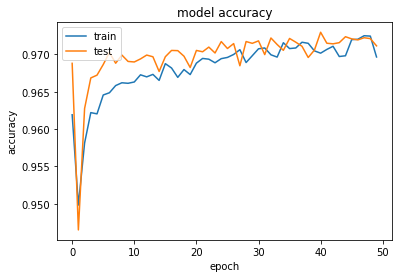

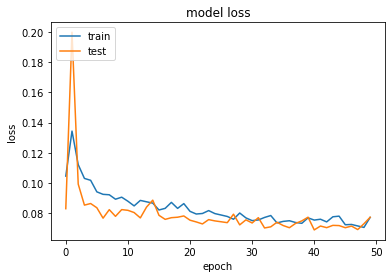

In [199]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [200]:
IOU = iou_score(Y_test, preds_test_bs_32)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_bs_32)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_bs_32.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8263590248682182

Dice coefficient: 0.90492475

Precision: 0.9475986713832099
Recall: 0.920339304010848
F1-score: 0.9337700857208043


In [72]:
checkpointer = ModelCheckpoint('unet_bs_64.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=64, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.7842
Epoch 1: val_loss improved from inf to 0.70705, saving model to unet_bs_64.h5
8/8 [==============================] - 75s 8s/step - loss: 0.5273 - accuracy: 0.7842 - val_loss: 0.7070 - val_accuracy: 0.4998
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.9224
Epoch 2: val_loss did not improve from 0.70705
8/8 [==============================] - 69s 8s/step - loss: 0.2621 - accuracy: 0.9224 - val_loss: 2.9252 - val_accuracy: 0.7219
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9488
Epoch 3: val_loss did not improve from 0.70705
8/8 [==============================] - 69s 9s/step - loss: 0.1896 - accuracy: 0.9488 - val_loss: 0.9408 - val_accuracy: 0.6984
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9534
Epoch 4: val_loss did not improve from 0.70705
8/8 [===========================

8/8 [==============================] - 68s 8s/step - loss: 0.0881 - accuracy: 0.9684 - val_loss: 0.6890 - val_accuracy: 0.7681
Epoch 32/50
8/8 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9645
Epoch 32: val_loss did not improve from 0.54673
8/8 [==============================] - 67s 8s/step - loss: 0.0981 - accuracy: 0.9645 - val_loss: 0.7567 - val_accuracy: 0.7591
Epoch 33/50
8/8 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9680
Epoch 33: val_loss improved from 0.54673 to 0.50444, saving model to unet_bs_64.h5
8/8 [==============================] - 68s 8s/step - loss: 0.0859 - accuracy: 0.9680 - val_loss: 0.5044 - val_accuracy: 0.8035
Epoch 34/50
8/8 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9680
Epoch 34: val_loss did not improve from 0.50444
8/8 [==============================] - 68s 8s/step - loss: 0.0872 - accuracy: 0.9680 - val_loss: 0.6828 - val_accuracy: 0.7627
Epoch 35/50
8/8 [=================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


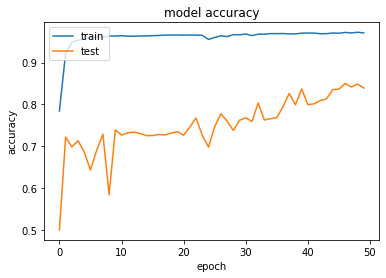

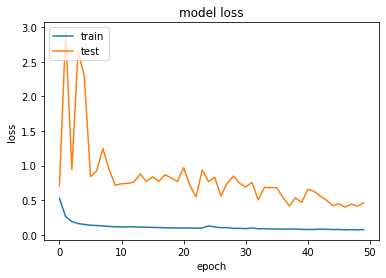

In [73]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
model_bs_64 = load_model('unet_bs_64.h5')
preds_test_bs_64 = model_bs_64.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_bs_64)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_bs_64)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_bs_64.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.5117863888960082

Dice coefficient: 0.67706203

Precision: 0.9218623069348052
Recall: 0.5967121258745515
F1-score: 0.7244773849076706


In [76]:
checkpointer = ModelCheckpoint('unet_bs_2.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
241/241 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9262
Epoch 1: val_loss improved from inf to 0.59417, saving model to unet_bs_2.h5
241/241 [==============================] - 110s 457ms/step - loss: 0.2142 - accuracy: 0.9262 - val_loss: 0.5942 - val_accuracy: 0.8796
Epoch 2/50
241/241 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9478
Epoch 2: val_loss improved from 0.59417 to 0.26926, saving model to unet_bs_2.h5
241/241 [==============================] - 109s 453ms/step - loss: 0.1455 - accuracy: 0.9478 - val_loss: 0.2693 - val_accuracy: 0.8796
Epoch 3/50
241/241 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9554
Epoch 3: val_loss did not improve from 0.26926
241/241 [==============================] - 111s 459ms/step - loss: 0.1272 - accuracy: 0.9554 - val_loss: 0.2858 - val_accuracy: 0.8897
Epoch 4/50
241/241 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.9569
Epoch 

Epoch 30/50
241/241 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9690
Epoch 30: val_loss improved from 0.13079 to 0.12890, saving model to unet_bs_2.h5
241/241 [==============================] - 106s 441ms/step - loss: 0.0807 - accuracy: 0.9690 - val_loss: 0.1289 - val_accuracy: 0.9590
Epoch 31/50
241/241 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9695
Epoch 31: val_loss did not improve from 0.12890
241/241 [==============================] - 106s 442ms/step - loss: 0.0810 - accuracy: 0.9695 - val_loss: 0.1953 - val_accuracy: 0.9099
Epoch 32/50
241/241 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9679
Epoch 32: val_loss improved from 0.12890 to 0.10201, saving model to unet_bs_2.h5
241/241 [==============================] - 107s 443ms/step - loss: 0.0834 - accuracy: 0.9679 - val_loss: 0.1020 - val_accuracy: 0.9616
Epoch 33/50
241/241 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


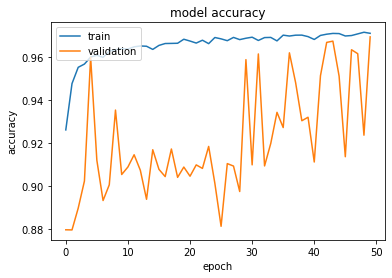

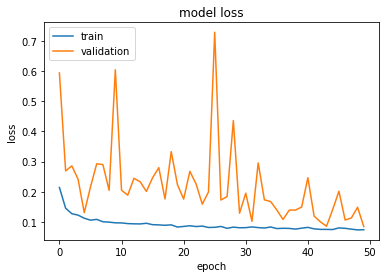

In [78]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [79]:
model_bs_2 = load_model('unet_bs_2.h5')
preds_test_bs_2 = model_bs_2.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_bs_2)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_bs_2)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_bs_2.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8082257900016188

Dice coefficient: 0.8939437

Precision: 0.933714353251051
Recall: 0.935015200035168
F1-score: 0.9343643238749835


## Optimizer

The optimum learning rate for one optimizer, such as Adam, may not be the optimum learning rate for other optimizers such as SGD or RMSprop. Therefore, it is generally a good practice to perform a hyperparameter search for each optimizer separately to find the optimal learning rate for that particular optimizer.

In other words, we should experiment with different learning rates for each optimizer and select the one that gives us the best performance on our validation set. The optimal learning rate will depend on the specifics of our dataset, model architecture, and training setup.

That being said, we can start with the same learning rate that worked well for Adam and then fine-tune it for the other optimizers during the hyperparameter search.

__________________________________________________________________________________________________________________
The choice of momentum for SGD can also have a significant impact on the performance of our model. Momentum can be used to accelerate convergence and smooth out the stochastic gradient updates. A momentum value of 0.9 is a common default value that often works well in practice, but it is not necessarily the best value for all cases.

Therefore, we should experiment with different momentum values for SGD during the hyperparameter search to find the optimal value for our specific problem. In general, it is a good idea to try a range of momentum values, such as 0.5, 0.9, and 0.99, to see which one gives the best performance.

Remember that the optimal values for hyperparameters such as learning rate and momentum can be different for different optimizers, so it is important to perform a separate hyperparameter search for each optimizer we use.

In [31]:
from keras.optimizers import SGD
optimizer = SGD(lr=0.01, momentum=0.9)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['lambda[0][0]']                 
                                )                                                                 
                                                                                            

                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 256)  884992      ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_5 (Dropout)            (None, 16, 16, 256)  0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 256)  590080      ['dropout_5[0][0]']              
          

/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
checkpointer = ModelCheckpoint('unet_sgd_1.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.8060
Epoch 1: val_loss improved from inf to 0.79593, saving model to unet_sgd_1.h5
31/31 [==============================] - 69s 2s/step - loss: 0.4627 - accuracy: 0.8060 - val_loss: 0.7959 - val_accuracy: 0.2986
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.8766
Epoch 2: val_loss improved from 0.79593 to 0.57509, saving model to unet_sgd_1.h5
31/31 [==============================] - 68s 2s/step - loss: 0.3306 - accuracy: 0.8766 - val_loss: 0.5751 - val_accuracy: 0.7251
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9149 
Epoch 3: val_loss improved from 0.57509 to 0.56664, saving model to unet_sgd_1.h5
31/31 [==============================] - 311s 10s/step - loss: 0.2297 - accuracy: 0.9149 - val_loss: 0.5666 - val_accuracy: 0.7845
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.1915 - accuracy:

31/31 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9617
Epoch 29: val_loss did not improve from 0.08502
31/31 [==============================] - 211s 7s/step - loss: 0.1006 - accuracy: 0.9617 - val_loss: 0.0988 - val_accuracy: 0.9633
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9601
Epoch 30: val_loss did not improve from 0.08502
31/31 [==============================] - 68s 2s/step - loss: 0.1056 - accuracy: 0.9601 - val_loss: 0.1056 - val_accuracy: 0.9603
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9630
Epoch 31: val_loss did not improve from 0.08502
31/31 [==============================] - 79s 3s/step - loss: 0.0967 - accuracy: 0.9630 - val_loss: 0.1005 - val_accuracy: 0.9628
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9631
Epoch 32: val_loss improved from 0.08502 to 0.08390, saving model to unet_sgd_1.h5
31/31 [==========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


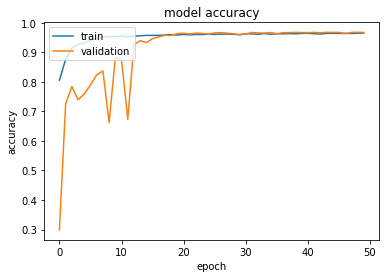

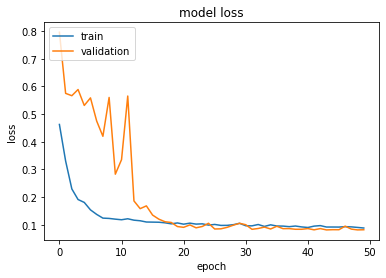

In [36]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [43]:
model_sgd_1 = load_model('unet_sgd_1.h5')
preds_test_sgd_1 = model_sgd_1.predict(X_test, verbose=0)

IOU = iou_score(Y_test, preds_test_sgd_1)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_sgd_1)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_sgd_1.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8263096095381667

Dice coefficient: 0.9048955

Precision: 0.9376695062067647
Recall: 0.9288658643392634
F1-score: 0.9332469237832094


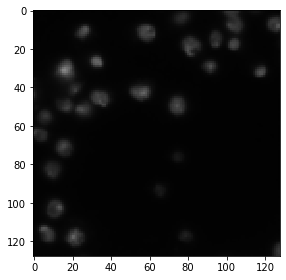

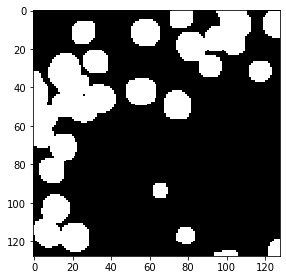

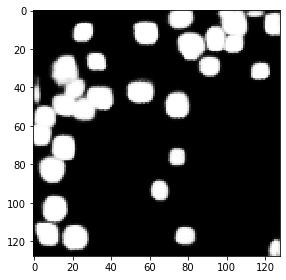

In [54]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test_sgd_1))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(Y_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_sgd_1[ix]))
plt.show()

In [47]:
from keras.optimizers import SGD
optimizer = SGD(lr=0.001, momentum=0.9)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['lambda[0][0]']                 
                                )                                                                 
                                                                                            

                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 256)  884992      ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_5 (Dropout)            (None, 16, 16, 256)  0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 256)  590080      ['dropout_5[0][0]']              
          

/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [220]:
checkpointer = ModelCheckpoint('unet_sgd_2.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9786
Epoch 1: val_loss improved from inf to 0.07315, saving model to unet_sgd_2.h5
31/31 [==============================] - 80s 2s/step - loss: 0.0589 - accuracy: 0.9786 - val_loss: 0.0731 - val_accuracy: 0.9731
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9786
Epoch 2: val_loss did not improve from 0.07315
31/31 [==============================] - 72s 2s/step - loss: 0.0600 - accuracy: 0.9786 - val_loss: 0.0737 - val_accuracy: 0.9730
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9785
Epoch 3: val_loss did not improve from 0.07315
31/31 [==============================] - 71s 2s/step - loss: 0.0600 - accuracy: 0.9785 - val_loss: 0.0737 - val_accuracy: 0.9731
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9786
Epoch 4: val_loss did not improve from 0.07315
31/31 [===========

31/31 [==============================] - 71s 2s/step - loss: 0.0591 - accuracy: 0.9788 - val_loss: 0.0729 - val_accuracy: 0.9731
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9786
Epoch 31: val_loss did not improve from 0.07260
31/31 [==============================] - 71s 2s/step - loss: 0.0597 - accuracy: 0.9786 - val_loss: 0.0729 - val_accuracy: 0.9730
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9786
Epoch 32: val_loss did not improve from 0.07260
31/31 [==============================] - 71s 2s/step - loss: 0.0591 - accuracy: 0.9786 - val_loss: 0.0729 - val_accuracy: 0.9731
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9789
Epoch 33: val_loss did not improve from 0.07260
31/31 [==============================] - 71s 2s/step - loss: 0.0584 - accuracy: 0.9789 - val_loss: 0.0731 - val_accuracy: 0.9731
Epoch 34/50
31/31 [==============================] - ET

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


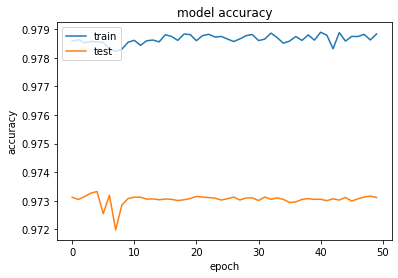

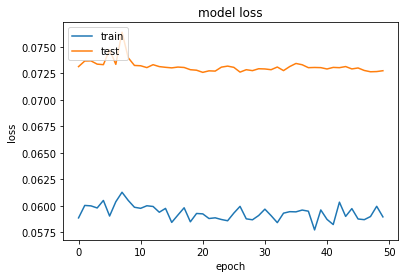

In [223]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [224]:
model_sgd_2 = load_model('unet_sgd_2.h5')
preds_test_sgd_2 = model_sgd_2.predict(X_test, verbose=0)

IOU = iou_score(Y_test, preds_test_sgd_2)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_sgd_2)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_sgd_2.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8619549935215561

Dice coefficient: 0.9151481

Precision: 0.9441363110591001
Recall: 0.9425830929619948
F1-score: 0.943359062676884


In [225]:
from keras.optimizers import SGD
optimizer = SGD(lr=0.0001, momentum=0.9)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_19 (Lambda)             (None, 128, 128, 3)  0           ['input_23[0][0]']               
                                                                                                  
 conv2d_342 (Conv2D)            (None, 128, 128, 32  896         ['lambda_19[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_transpose_20 (Conv2DTra  (None, 16, 16, 128)  262272     ['batch_normalization_83[0][0]'] 
 nspose)                                                                                          
                                                                                                  
 concatenate_61 (Concatenate)   (None, 16, 16, 384)  0           ['conv2d_transpose_20[0][0]',    
                                                                  'batch_normalization_81[0][0]'] 
                                                                                                  
 conv2d_352 (Conv2D)            (None, 16, 16, 256)  884992      ['concatenate_61[0][0]']         
                                                                                                  
 batch_normalization_84 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_352[0][0]']             
 ormalization)                                                                                    
          

/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [226]:
checkpointer = ModelCheckpoint('unet_sgd_3.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9789
Epoch 1: val_loss improved from inf to 0.07289, saving model to unet_sgd_3.h5
31/31 [==============================] - 71s 2s/step - loss: 0.0588 - accuracy: 0.9789 - val_loss: 0.0729 - val_accuracy: 0.9731
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9787
Epoch 2: val_loss improved from 0.07289 to 0.07278, saving model to unet_sgd_3.h5
31/31 [==============================] - 73s 2s/step - loss: 0.0599 - accuracy: 0.9787 - val_loss: 0.0728 - val_accuracy: 0.9731
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9787
Epoch 3: val_loss improved from 0.07278 to 0.07263, saving model to unet_sgd_3.h5
31/31 [==============================] - 71s 2s/step - loss: 0.0595 - accuracy: 0.9787 - val_loss: 0.0726 - val_accuracy: 0.9731
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


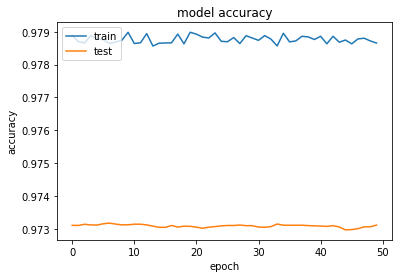

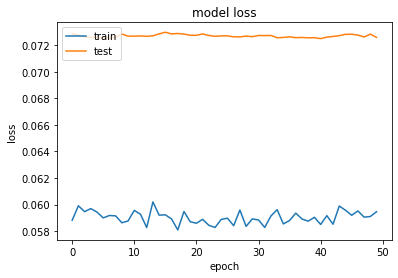

In [227]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [228]:
model_sgd_3 = load_model('unet_sgd_3.h5')
preds_test_sgd_3 = model_sgd_3.predict(X_test, verbose=0)

IOU = iou_score(Y_test, preds_test_sgd_3)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_sgd_3)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_sgd_3.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8620320446298249

Dice coefficient: 0.9151008

Precision: 0.9436779743548125
Recall: 0.9436939297924071
F1-score: 0.9436859520061679


In [229]:
optimizer = SGD(lr=0.1, momentum=0.9)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_19 (Lambda)             (None, 128, 128, 3)  0           ['input_23[0][0]']               
                                                                                                  
 conv2d_342 (Conv2D)            (None, 128, 128, 32  896         ['lambda_19[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_transpose_20 (Conv2DTra  (None, 16, 16, 128)  262272     ['batch_normalization_83[0][0]'] 
 nspose)                                                                                          
                                                                                                  
 concatenate_61 (Concatenate)   (None, 16, 16, 384)  0           ['conv2d_transpose_20[0][0]',    
                                                                  'batch_normalization_81[0][0]'] 
                                                                                                  
 conv2d_352 (Conv2D)            (None, 16, 16, 256)  884992      ['concatenate_61[0][0]']         
                                                                                                  
 batch_normalization_84 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_352[0][0]']             
 ormalization)                                                                                    
          

/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [230]:
checkpointer = ModelCheckpoint('unet_sgd_4.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9778
Epoch 1: val_loss improved from inf to 0.09693, saving model to unet_sgd_4.h5
31/31 [==============================] - 76s 2s/step - loss: 0.0618 - accuracy: 0.9778 - val_loss: 0.0969 - val_accuracy: 0.9654
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9762
Epoch 2: val_loss did not improve from 0.09693
31/31 [==============================] - 66s 2s/step - loss: 0.0656 - accuracy: 0.9762 - val_loss: 0.4541 - val_accuracy: 0.8586
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9746
Epoch 3: val_loss did not improve from 0.09693
31/31 [==============================] - 67s 2s/step - loss: 0.0723 - accuracy: 0.9746 - val_loss: 0.6905 - val_accuracy: 0.8207
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9747
Epoch 4: val_loss did not improve from 0.09693
31/31 [===========

31/31 [==============================] - 68s 2s/step - loss: 0.0607 - accuracy: 0.9775 - val_loss: 0.0874 - val_accuracy: 0.9696
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9775
Epoch 31: val_loss did not improve from 0.07668
31/31 [==============================] - 68s 2s/step - loss: 0.0603 - accuracy: 0.9775 - val_loss: 0.0799 - val_accuracy: 0.9715
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9780
Epoch 32: val_loss did not improve from 0.07668
31/31 [==============================] - 68s 2s/step - loss: 0.0584 - accuracy: 0.9780 - val_loss: 0.0778 - val_accuracy: 0.9708
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9780
Epoch 33: val_loss did not improve from 0.07668
31/31 [==============================] - 68s 2s/step - loss: 0.0592 - accuracy: 0.9780 - val_loss: 0.0781 - val_accuracy: 0.9711
Epoch 34/50
31/31 [==============================] - ET

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


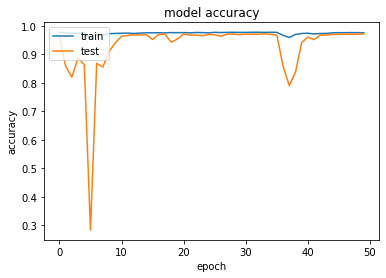

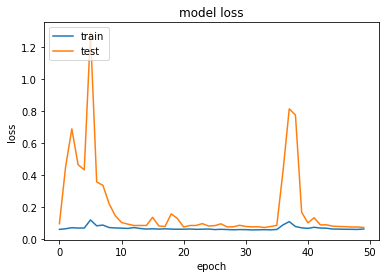

In [231]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [232]:
model_sgd_4 = load_model('unet_sgd_4.h5')
preds_test_sgd_4 = model_sgd_4.predict(X_test, verbose=0)

IOU = iou_score(Y_test, preds_test_sgd_4)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_sgd_4)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_sgd_4.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8523605005950198

Dice coefficient: 0.90877473

Precision: 0.9429648933600514
Recall: 0.937257162953169
F1-score: 0.9401023647686108


In [234]:
from keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.001, rho=0.9)

In [235]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_19 (Lambda)             (None, 128, 128, 3)  0           ['input_23[0][0]']               
                                                                                                  
 conv2d_342 (Conv2D)            (None, 128, 128, 32  896         ['lambda_19[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_transpose_20 (Conv2DTra  (None, 16, 16, 128)  262272     ['batch_normalization_83[0][0]'] 
 nspose)                                                                                          
                                                                                                  
 concatenate_61 (Concatenate)   (None, 16, 16, 384)  0           ['conv2d_transpose_20[0][0]',    
                                                                  'batch_normalization_81[0][0]'] 
                                                                                                  
 conv2d_352 (Conv2D)            (None, 16, 16, 256)  884992      ['concatenate_61[0][0]']         
                                                                                                  
 batch_normalization_84 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_352[0][0]']             
 ormalization)                                                                                    
          

In [236]:
checkpointer = ModelCheckpoint('unet_RMSprop1.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9733
Epoch 1: val_loss improved from inf to 0.08118, saving model to unet_RMSprop1.h5
31/31 [==============================] - 88s 2s/step - loss: 0.0715 - accuracy: 0.9733 - val_loss: 0.0812 - val_accuracy: 0.9702
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9750
Epoch 2: val_loss improved from 0.08118 to 0.07634, saving model to unet_RMSprop1.h5
31/31 [==============================] - 67s 2s/step - loss: 0.0661 - accuracy: 0.9750 - val_loss: 0.0763 - val_accuracy: 0.9710
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9755
Epoch 3: val_loss improved from 0.07634 to 0.07353, saving model to unet_RMSprop1.h5
31/31 [==============================] - 66s 2s/step - loss: 0.0646 - accuracy: 0.9755 - val_loss: 0.0735 - val_accuracy: 0.9717
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0639 - acc

31/31 [==============================] - 69s 2s/step - loss: 0.0490 - accuracy: 0.9805 - val_loss: 0.0875 - val_accuracy: 0.9707
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9805
Epoch 31: val_loss did not improve from 0.06991
31/31 [==============================] - 69s 2s/step - loss: 0.0485 - accuracy: 0.9805 - val_loss: 0.0800 - val_accuracy: 0.9710
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9805
Epoch 32: val_loss did not improve from 0.06991
31/31 [==============================] - 69s 2s/step - loss: 0.0482 - accuracy: 0.9805 - val_loss: 0.0746 - val_accuracy: 0.9729
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9811
Epoch 33: val_loss did not improve from 0.06991
31/31 [==============================] - 68s 2s/step - loss: 0.0470 - accuracy: 0.9811 - val_loss: 0.0922 - val_accuracy: 0.9685
Epoch 34/50
31/31 [==============================] - ET

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


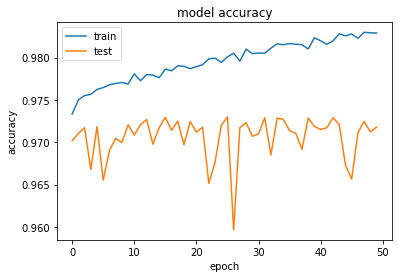

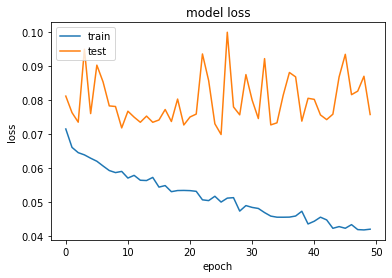

In [237]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [238]:
model_rms_1 = load_model('unet_RMSprop1.h5')
preds_test_rms_1 = model_rms_1.predict(X_test, verbose=0)

IOU = iou_score(Y_test, preds_test_rms_1)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_rms_1)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_rms_1.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8661748184902655

Dice coefficient: 0.9180193

Precision: 0.9436572427430839
Recall: 0.9456197184527413
F1-score: 0.9446374613426657


In [239]:
optimizer = RMSprop(learning_rate=0.01, rho=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_19 (Lambda)             (None, 128, 128, 3)  0           ['input_23[0][0]']               
                                                                                                  
 conv2d_342 (Conv2D)            (None, 128, 128, 32  896         ['lambda_19[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_transpose_20 (Conv2DTra  (None, 16, 16, 128)  262272     ['batch_normalization_83[0][0]'] 
 nspose)                                                                                          
                                                                                                  
 concatenate_61 (Concatenate)   (None, 16, 16, 384)  0           ['conv2d_transpose_20[0][0]',    
                                                                  'batch_normalization_81[0][0]'] 
                                                                                                  
 conv2d_352 (Conv2D)            (None, 16, 16, 256)  884992      ['concatenate_61[0][0]']         
                                                                                                  
 batch_normalization_84 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_352[0][0]']             
 ormalization)                                                                                    
          

In [240]:
checkpointer = ModelCheckpoint('unet_RMSprop2.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.3477 - accuracy: 0.9029
Epoch 1: val_loss improved from inf to 0.58265, saving model to unet_RMSprop2.h5
31/31 [==============================] - 79s 2s/step - loss: 0.3477 - accuracy: 0.9029 - val_loss: 0.5826 - val_accuracy: 0.8518
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9328
Epoch 2: val_loss did not improve from 0.58265
31/31 [==============================] - 65s 2s/step - loss: 0.1756 - accuracy: 0.9328 - val_loss: 40.0419 - val_accuracy: 0.3452
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9476
Epoch 3: val_loss did not improve from 0.58265
31/31 [==============================] - 65s 2s/step - loss: 0.1378 - accuracy: 0.9476 - val_loss: 38.4587 - val_accuracy: 0.3081
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.9522
Epoch 4: val_loss did not improve from 0.58265
31/31 [======

31/31 [==============================] - 71s 2s/step - loss: 0.0833 - accuracy: 0.9686 - val_loss: 0.0915 - val_accuracy: 0.9658
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9689
Epoch 31: val_loss did not improve from 0.08151
31/31 [==============================] - 68s 2s/step - loss: 0.0803 - accuracy: 0.9689 - val_loss: 0.0852 - val_accuracy: 0.9659
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9707
Epoch 32: val_loss did not improve from 0.08151
31/31 [==============================] - 69s 2s/step - loss: 0.0756 - accuracy: 0.9707 - val_loss: 0.0998 - val_accuracy: 0.9602
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9691
Epoch 33: val_loss did not improve from 0.08151
31/31 [==============================] - 68s 2s/step - loss: 0.0806 - accuracy: 0.9691 - val_loss: 0.0982 - val_accuracy: 0.9610
Epoch 34/50
31/31 [==============================] - ET

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


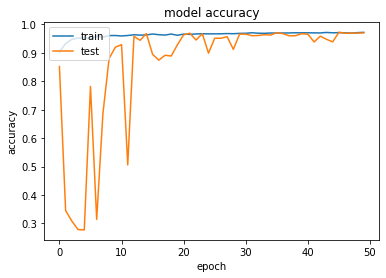

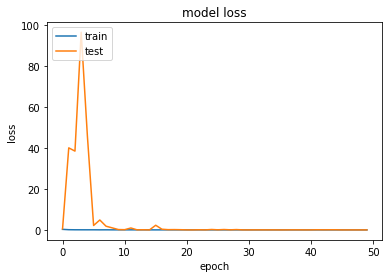

In [241]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [244]:
model_rms_2 = load_model('unet_RMSprop2.h5')
preds_test_rms_2 = model_rms_2.predict(X_test, verbose=0)

IOU = iou_score(Y_test, preds_test_rms_2)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_rms_2)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_rms_2.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8588191063117064

Dice coefficient: 0.9129817

Precision: 0.9410135297685404
Recall: 0.9391170115276796
F1-score: 0.9400643141237202


In [242]:
optimizer = RMSprop(learning_rate=0.1, rho=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_19 (Lambda)             (None, 128, 128, 3)  0           ['input_23[0][0]']               
                                                                                                  
 conv2d_342 (Conv2D)            (None, 128, 128, 32  896         ['lambda_19[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_transpose_20 (Conv2DTra  (None, 16, 16, 128)  262272     ['batch_normalization_83[0][0]'] 
 nspose)                                                                                          
                                                                                                  
 concatenate_61 (Concatenate)   (None, 16, 16, 384)  0           ['conv2d_transpose_20[0][0]',    
                                                                  'batch_normalization_81[0][0]'] 
                                                                                                  
 conv2d_352 (Conv2D)            (None, 16, 16, 256)  884992      ['concatenate_61[0][0]']         
                                                                                                  
 batch_normalization_84 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_352[0][0]']             
 ormalization)                                                                                    
          

In [243]:
checkpointer = ModelCheckpoint('unet_RMSprop3.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.7821
Epoch 1: val_loss improved from inf to 8604.01855, saving model to unet_RMSprop3.h5
31/31 [==============================] - 80s 2s/step - loss: 0.6565 - accuracy: 0.7821 - val_loss: 8604.0186 - val_accuracy: 0.2749
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.3780 - accuracy: 0.8487
Epoch 2: val_loss improved from 8604.01855 to 354.43866, saving model to unet_RMSprop3.h5
31/31 [==============================] - 67s 2s/step - loss: 0.3780 - accuracy: 0.8487 - val_loss: 354.4387 - val_accuracy: 0.2904
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.8627
Epoch 3: val_loss improved from 354.43866 to 7.13808, saving model to unet_RMSprop3.h5
31/31 [==============================] - 74s 2s/step - loss: 0.3351 - accuracy: 0.8627 - val_loss: 7.1381 - val_accuracy: 0.4320
Epoch 4/50
31/31 [==============================] - ETA: 0s - los

31/31 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9558
Epoch 30: val_loss did not improve from 0.10795
31/31 [==============================] - 82s 3s/step - loss: 0.1140 - accuracy: 0.9558 - val_loss: 0.2408 - val_accuracy: 0.9325
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9594
Epoch 31: val_loss did not improve from 0.10795
31/31 [==============================] - 81s 3s/step - loss: 0.1055 - accuracy: 0.9594 - val_loss: 0.2084 - val_accuracy: 0.9331
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9569
Epoch 32: val_loss did not improve from 0.10795
31/31 [==============================] - 81s 3s/step - loss: 0.1140 - accuracy: 0.9569 - val_loss: 0.4096 - val_accuracy: 0.8770
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9596
Epoch 33: val_loss did not improve from 0.10795
31/31 [==============================] - 70s 2s/step 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


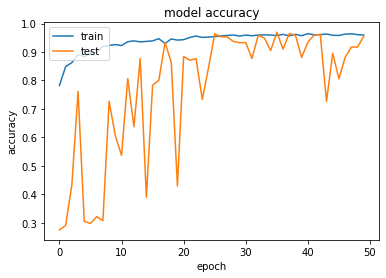

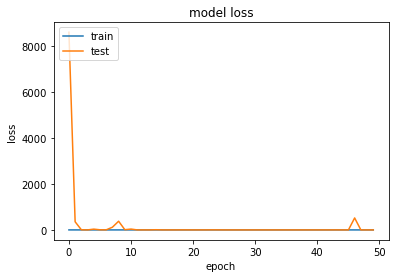

In [245]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [246]:
model_rms_3 = load_model('unet_RMSprop3.h5')
preds_test_rms_3 = model_rms_3.predict(X_test, verbose=0)

IOU = iou_score(Y_test, preds_test_rms_3)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_rms_3)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_rms_3.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8511349734260094

Dice coefficient: 0.9033137

Precision: 0.9283770516206402
Recall: 0.9384778999266206
F1-score: 0.9334001498326364


In [247]:
# momentum 0.5
optimizer = SGD(lr=0.01, momentum=0.5)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_19 (Lambda)             (None, 128, 128, 3)  0           ['input_23[0][0]']               
                                                                                                  
 conv2d_342 (Conv2D)            (None, 128, 128, 32  896         ['lambda_19[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_transpose_20 (Conv2DTra  (None, 16, 16, 128)  262272     ['batch_normalization_83[0][0]'] 
 nspose)                                                                                          
                                                                                                  
 concatenate_61 (Concatenate)   (None, 16, 16, 384)  0           ['conv2d_transpose_20[0][0]',    
                                                                  'batch_normalization_81[0][0]'] 
                                                                                                  
 conv2d_352 (Conv2D)            (None, 16, 16, 256)  884992      ['concatenate_61[0][0]']         
                                                                                                  
 batch_normalization_84 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_352[0][0]']             
 ormalization)                                                                                    
          

/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [248]:
checkpointer = ModelCheckpoint('unet_RMSprop4.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9663
Epoch 1: val_loss improved from inf to 0.11655, saving model to unet_RMSprop4.h5
31/31 [==============================] - 75s 2s/step - loss: 0.0975 - accuracy: 0.9663 - val_loss: 0.1165 - val_accuracy: 0.9596
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9666
Epoch 2: val_loss improved from 0.11655 to 0.10374, saving model to unet_RMSprop4.h5
31/31 [==============================] - 71s 2s/step - loss: 0.0962 - accuracy: 0.9666 - val_loss: 0.1037 - val_accuracy: 0.9625
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9673
Epoch 3: val_loss improved from 0.10374 to 0.09704, saving model to unet_RMSprop4.h5
31/31 [==============================] - 71s 2s/step - loss: 0.0933 - accuracy: 0.9673 - val_loss: 0.0970 - val_accuracy: 0.9642
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0945 - acc

31/31 [==============================] - 74s 2s/step - loss: 0.0875 - accuracy: 0.9676 - val_loss: 5.8945 - val_accuracy: 0.9630
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9670
Epoch 31: val_loss did not improve from 0.09099
31/31 [==============================] - 76s 2s/step - loss: 0.0894 - accuracy: 0.9670 - val_loss: 6.3995 - val_accuracy: 0.9630
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9672
Epoch 32: val_loss did not improve from 0.09099
31/31 [==============================] - 76s 2s/step - loss: 0.0880 - accuracy: 0.9672 - val_loss: 6.7253 - val_accuracy: 0.9631
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9672
Epoch 33: val_loss did not improve from 0.09099
31/31 [==============================] - 75s 2s/step - loss: 0.0883 - accuracy: 0.9672 - val_loss: 6.2251 - val_accuracy: 0.9633
Epoch 34/50
31/31 [==============================] - ET

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


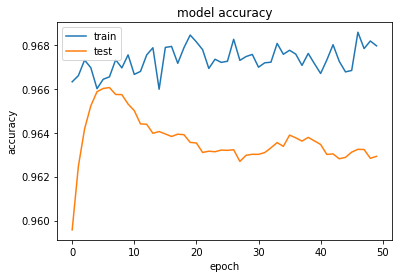

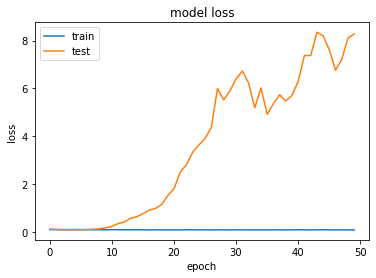

In [250]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [252]:
model_rms_4 = load_model('unet_RMSprop4.h5')
preds_test_rms_4 = model_rms_4.predict(X_test, verbose=0)

IOU = iou_score(Y_test, preds_test_rms_4)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_rms_4)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_rms_4.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8377604716528928

Dice coefficient: 0.88827217

Precision: 0.9085941500256016
Recall: 0.9600791957338455
F1-score: 0.9336274237384558


In [253]:
# momentum is 0.99
optimizer = SGD(lr=0.01, momentum=0.99)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_19 (Lambda)             (None, 128, 128, 3)  0           ['input_23[0][0]']               
                                                                                                  
 conv2d_342 (Conv2D)            (None, 128, 128, 32  896         ['lambda_19[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_transpose_20 (Conv2DTra  (None, 16, 16, 128)  262272     ['batch_normalization_83[0][0]'] 
 nspose)                                                                                          
                                                                                                  
 concatenate_61 (Concatenate)   (None, 16, 16, 384)  0           ['conv2d_transpose_20[0][0]',    
                                                                  'batch_normalization_81[0][0]'] 
                                                                                                  
 conv2d_352 (Conv2D)            (None, 16, 16, 256)  884992      ['concatenate_61[0][0]']         
                                                                                                  
 batch_normalization_84 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_352[0][0]']             
 ormalization)                                                                                    
          

/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [254]:
checkpointer = ModelCheckpoint('unet_RMSprop5.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9669
Epoch 1: val_loss improved from inf to 7.17985, saving model to unet_RMSprop5.h5
31/31 [==============================] - 76s 2s/step - loss: 0.0894 - accuracy: 0.9669 - val_loss: 7.1799 - val_accuracy: 0.9632
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9675
Epoch 2: val_loss improved from 7.17985 to 6.92789, saving model to unet_RMSprop5.h5
31/31 [==============================] - 66s 2s/step - loss: 0.0878 - accuracy: 0.9675 - val_loss: 6.9279 - val_accuracy: 0.9635
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9675
Epoch 3: val_loss improved from 6.92789 to 5.62118, saving model to unet_RMSprop5.h5
31/31 [==============================] - 65s 2s/step - loss: 0.0877 - accuracy: 0.9675 - val_loss: 5.6212 - val_accuracy: 0.9640
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0869 - acc

Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9691
Epoch 31: val_loss did not improve from 4.90286
31/31 [==============================] - 77s 2s/step - loss: 0.0806 - accuracy: 0.9691 - val_loss: 11.3821 - val_accuracy: 0.9630
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9689
Epoch 32: val_loss did not improve from 4.90286
31/31 [==============================] - 79s 3s/step - loss: 0.0818 - accuracy: 0.9689 - val_loss: 11.1505 - val_accuracy: 0.9630
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9693
Epoch 33: val_loss did not improve from 4.90286
31/31 [==============================] - 78s 3s/step - loss: 0.0806 - accuracy: 0.9693 - val_loss: 9.9852 - val_accuracy: 0.9630
Epoch 34/50
31/31 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9698
Epoch 34: val_loss did not improve from 4.90286
31/31 [==============================] 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


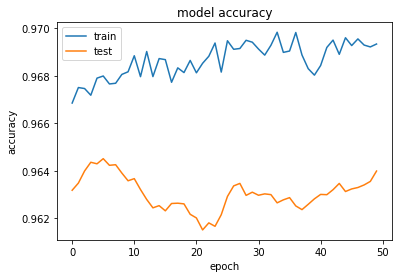

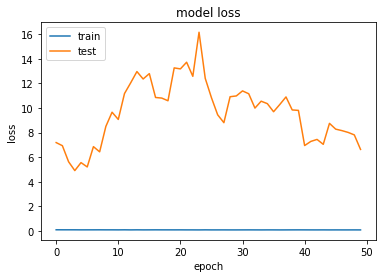

In [255]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loss Function

In [83]:
import keras.backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

# Register the custom loss function
custom_objects = {'dice_loss': dice_loss}

# Compile the model with the custom loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=dice_loss, metrics=[dice_coef, 'accuracy'])

# Train the model
# checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_dice_l.h5', verbose=1, save_best_only=True, monitor='val_loss')
# results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[checkpointer])


In [84]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_dice_l.h5', verbose=1, save_best_only=True, monitor='val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[checkpointer])


Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0842 - dice_coef: 0.9157 - accuracy: 0.9702
Epoch 1: val_loss improved from inf to 0.06616, saving model to unet_dice_l.h5
31/31 [==============================] - 77s 2s/step - loss: 0.0842 - dice_coef: 0.9157 - accuracy: 0.9702 - val_loss: 0.0662 - val_dice_coef: 0.9324 - val_accuracy: 0.9708
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0702 - dice_coef: 0.9301 - accuracy: 0.9713
Epoch 2: val_loss improved from 0.06616 to 0.06476, saving model to unet_dice_l.h5
31/31 [==============================] - 69s 2s/step - loss: 0.0702 - dice_coef: 0.9301 - accuracy: 0.9713 - val_loss: 0.0648 - val_dice_coef: 0.9338 - val_accuracy: 0.9711
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0662 - dice_coef: 0.9332 - accuracy: 0.9714
Epoch 3: val_loss improved from 0.06476 to 0.06447, saving model to unet_dice_l.h5
31/31 [==============================] - 68s 2s/step - loss: 0.0662

31/31 [==============================] - ETA: 0s - loss: 0.0556 - dice_coef: 0.9450 - accuracy: 0.9745
Epoch 24: val_loss did not improve from 0.05467
31/31 [==============================] - 69s 2s/step - loss: 0.0556 - dice_coef: 0.9450 - accuracy: 0.9745 - val_loss: 0.0565 - val_dice_coef: 0.9420 - val_accuracy: 0.9738
Epoch 25/50
31/31 [==============================] - ETA: 0s - loss: 0.0552 - dice_coef: 0.9450 - accuracy: 0.9744
Epoch 25: val_loss did not improve from 0.05467
31/31 [==============================] - 69s 2s/step - loss: 0.0552 - dice_coef: 0.9450 - accuracy: 0.9744 - val_loss: 0.0591 - val_dice_coef: 0.9388 - val_accuracy: 0.9730
Epoch 26/50
31/31 [==============================] - ETA: 0s - loss: 0.0548 - dice_coef: 0.9456 - accuracy: 0.9747
Epoch 26: val_loss did not improve from 0.05467
31/31 [==============================] - 69s 2s/step - loss: 0.0548 - dice_coef: 0.9456 - accuracy: 0.9747 - val_loss: 0.0557 - val_dice_coef: 0.9427 - val_accuracy: 0.9737
Epoc

31/31 [==============================] - 70s 2s/step - loss: 0.0513 - dice_coef: 0.9484 - accuracy: 0.9758 - val_loss: 0.0584 - val_dice_coef: 0.9403 - val_accuracy: 0.9718
Epoch 49/50
31/31 [==============================] - ETA: 0s - loss: 0.0504 - dice_coef: 0.9493 - accuracy: 0.9765
Epoch 49: val_loss did not improve from 0.05467
31/31 [==============================] - 68s 2s/step - loss: 0.0504 - dice_coef: 0.9493 - accuracy: 0.9765 - val_loss: 0.0553 - val_dice_coef: 0.9430 - val_accuracy: 0.9738
Epoch 50/50
31/31 [==============================] - ETA: 0s - loss: 0.0503 - dice_coef: 0.9497 - accuracy: 0.9763
Epoch 50: val_loss did not improve from 0.05467
31/31 [==============================] - 69s 2s/step - loss: 0.0503 - dice_coef: 0.9497 - accuracy: 0.9763 - val_loss: 0.0560 - val_dice_coef: 0.9422 - val_accuracy: 0.9741


dict_keys(['loss', 'dice_coef', 'accuracy', 'val_loss', 'val_dice_coef', 'val_accuracy'])


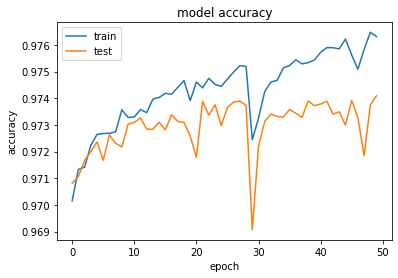

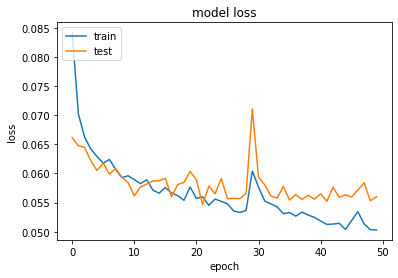

In [85]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

In [88]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

In [92]:
from keras.models import load_model
from keras.metrics import binary_crossentropy
from keras.utils import CustomObjectScope

def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

# load model with custom object scope
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef}):
    model_dice_1 = load_model('unet_dice_l.h5')

preds_test_dice_1 = model_dice_1.predict(X_test, verbose=0)

IOU = iou_score(Y_test, preds_test_dice_1)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_dice_1)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_dice_1.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8901262475865837

Dice coefficient: 0.9339731

Precision: 0.9384678575320419
Recall: 0.9464634133969965
F1-score: 0.9424486775747076


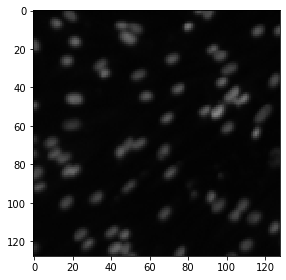

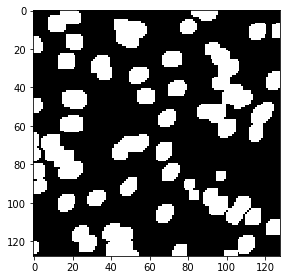

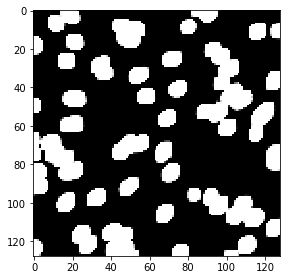

In [94]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test_dice_1))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(Y_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_dice_1[ix]))
plt.show()

In [209]:
import tensorflow as tf
from tensorflow.keras.backend import epsilon

def jaccard_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    sum_ = tf.reduce_sum(y_true + y_pred, axis=[1,2])
    jac = (intersection + epsilon()) / (sum_ - intersection + epsilon())
    return tf.reduce_mean(1 - jac)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with the new optimizer and loss function
model.compile(optimizer=optimizer, loss=jaccard_loss, metrics=['accuracy'])

In [210]:
# Train the model
checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_jaccard_l.h5', verbose=1, save_best_only=True, monitor='val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[checkpointer])


Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9757
Epoch 1: val_loss improved from inf to 0.11236, saving model to unet_jaccard_l.h5
31/31 [==============================] - 80s 2s/step - loss: 0.0939 - accuracy: 0.9757 - val_loss: 0.1124 - val_accuracy: 0.9706
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9755
Epoch 2: val_loss improved from 0.11236 to 0.10514, saving model to unet_jaccard_l.h5
31/31 [==============================] - 65s 2s/step - loss: 0.0955 - accuracy: 0.9755 - val_loss: 0.1051 - val_accuracy: 0.9732
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9756
Epoch 3: val_loss did not improve from 0.10514
31/31 [==============================] - 64s 2s/step - loss: 0.0972 - accuracy: 0.9756 - val_loss: 0.1060 - val_accuracy: 0.9732
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9763
Epoch 4: val_loss impr

Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9782
Epoch 31: val_loss did not improve from 0.10299
31/31 [==============================] - 65s 2s/step - loss: 0.0837 - accuracy: 0.9782 - val_loss: 0.1078 - val_accuracy: 0.9725
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9788
Epoch 32: val_loss did not improve from 0.10299
31/31 [==============================] - 65s 2s/step - loss: 0.0817 - accuracy: 0.9788 - val_loss: 0.1088 - val_accuracy: 0.9721
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9786
Epoch 33: val_loss did not improve from 0.10299
31/31 [==============================] - 65s 2s/step - loss: 0.0818 - accuracy: 0.9786 - val_loss: 0.1180 - val_accuracy: 0.9684
Epoch 34/50
31/31 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9793
Epoch 34: val_loss did not improve from 0.10299
31/31 [==============================] - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


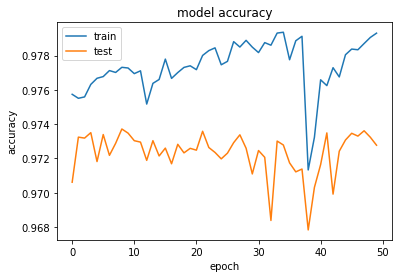

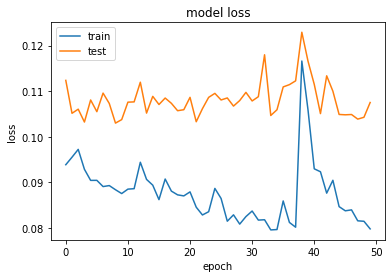

In [211]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [212]:
IOU = iou_score(Y_test, preds_test_bs_32)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_bs_32)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_bs_32.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8263590248682182

Dice coefficient: 0.88291126

Precision: 0.9475986713832099
Recall: 0.920339304010848
F1-score: 0.9337700857208043


#### For SGD
The choice of loss function depends on the specific problem and the nature of the data. In the case of nuclei segmentation, binary crossentropy is a commonly used loss function when segmenting binary masks. However, other loss functions like dice loss, focal loss, or Tversky loss can also be used for segmentation tasks.

With the SGD optimizer, sparse categorical crossentropy is often used for multiclass classification problems. However, if we are performing binary segmentation, binary crossentropy is still a good choice.

In [282]:
from keras.optimizers import SGD
optimizer = SGD(lr=0.01, momentum=0.9)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss=dice_loss, metrics=[dice_coef, 'accuracy'])
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_23 (Lambda)             (None, 128, 128, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv2d_438 (Conv2D)            (None, 128, 128, 32  896         ['lambda_23[0][0]']              
                                )                                                                 
                                                                                           

 batch_normalization_163 (Batch  (None, 16, 16, 256)  1024       ['leaky_re_lu_7[0][0]']          
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_97 (MaxPooling2D  (None, 8, 8, 256)   0           ['batch_normalization_163[0][0]']
 )                                                                                                
                                                                                                  
 conv2d_446 (Conv2D)            (None, 8, 8, 512)    1180160     ['max_pooling2d_97[0][0]']       
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 8, 8, 512)    0           ['conv2d_446[0][0]']             
                                                                                                  
 batch_nor

 leaky_re_lu_15 (LeakyReLU)     (None, 64, 64, 64)   0           ['conv2d_453[0][0]']             
                                                                                                  
 batch_normalization_171 (Batch  (None, 64, 64, 64)  256         ['leaky_re_lu_15[0][0]']         
 Normalization)                                                                                   
                                                                                                  
 conv2d_transpose_31 (Conv2DTra  (None, 128, 128, 32  8224       ['batch_normalization_171[0][0]']
 nspose)                        )                                                                 
                                                                                                  
 concatenate_82 (Concatenate)   (None, 128, 128, 64  0           ['conv2d_transpose_31[0][0]',    
                                )                                 'batch_normalization_157[0][0]']
          

In [283]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_sgddice_l.h5', verbose=1, save_best_only=True, monitor='val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.4904 - dice_coef: 0.5145 - accuracy: 0.6849
Epoch 1: val_loss improved from inf to 0.60807, saving model to unet_sgddice_l.h5
31/31 [==============================] - 90s 3s/step - loss: 0.4904 - dice_coef: 0.5145 - accuracy: 0.6849 - val_loss: 0.6081 - val_dice_coef: 0.3994 - val_accuracy: 0.2749
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.3270 - dice_coef: 0.6688 - accuracy: 0.7624
Epoch 2: val_loss improved from 0.60807 to 0.59626, saving model to unet_sgddice_l.h5
31/31 [==============================] - 76s 2s/step - loss: 0.3270 - dice_coef: 0.6688 - accuracy: 0.7624 - val_loss: 0.5963 - val_dice_coef: 0.4119 - val_accuracy: 0.2749
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.2929 - dice_coef: 0.7129 - accuracy: 0.7889
Epoch 3: val_loss improved from 0.59626 to 0.59592, saving model to unet_sgddice_l.h5
31/31 [==============================] - 76s 2s/step - los

Epoch 48/50
31/31 [==============================] - ETA: 0s - loss: 0.0894 - dice_coef: 0.9109 - accuracy: 0.9617
Epoch 48: val_loss did not improve from 0.07504
31/31 [==============================] - 78s 3s/step - loss: 0.0894 - dice_coef: 0.9109 - accuracy: 0.9617 - val_loss: 0.0920 - val_dice_coef: 0.9064 - val_accuracy: 0.9550
Epoch 49/50
31/31 [==============================] - ETA: 0s - loss: 0.0879 - dice_coef: 0.9109 - accuracy: 0.9619
Epoch 49: val_loss did not improve from 0.07504
31/31 [==============================] - 77s 2s/step - loss: 0.0879 - dice_coef: 0.9109 - accuracy: 0.9619 - val_loss: 0.0778 - val_dice_coef: 0.9205 - val_accuracy: 0.9642
Epoch 50/50
31/31 [==============================] - ETA: 0s - loss: 0.0849 - dice_coef: 0.9126 - accuracy: 0.9633
Epoch 50: val_loss did not improve from 0.07504
31/31 [==============================] - 76s 2s/step - loss: 0.0849 - dice_coef: 0.9126 - accuracy: 0.9633 - val_loss: 0.0780 - val_dice_coef: 0.9199 - val_accuracy:

dict_keys(['loss', 'dice_coef', 'accuracy', 'val_loss', 'val_dice_coef', 'val_accuracy'])


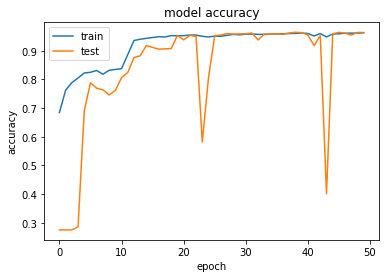

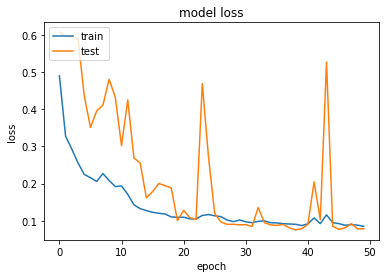

In [284]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [285]:
IOU = iou_score(Y_test, preds_test_bs_32)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_bs_32)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_bs_32.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8263590248682182

Dice coefficient: 0.88291126

Precision: 0.9475986713832099
Recall: 0.920339304010848
F1-score: 0.9337700857208043


In [286]:
model.compile(optimizer=optimizer, loss=jaccard_loss, metrics=['accuracy'])

In [287]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_sgdjac_l.h5', verbose=1, save_best_only=True, monitor='val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9584
Epoch 1: val_loss improved from inf to 0.66024, saving model to unet_sgdjac_l.h5
31/31 [==============================] - 88s 3s/step - loss: 0.1654 - accuracy: 0.9584 - val_loss: 0.6602 - val_accuracy: 0.3762
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9604
Epoch 2: val_loss improved from 0.66024 to 0.64681, saving model to unet_sgdjac_l.h5
31/31 [==============================] - 77s 2s/step - loss: 0.1581 - accuracy: 0.9604 - val_loss: 0.6468 - val_accuracy: 0.4476
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9597
Epoch 3: val_loss improved from 0.64681 to 0.53228, saving model to unet_sgdjac_l.h5
31/31 [==============================] - 77s 2s/step - loss: 0.1598 - accuracy: 0.9597 - val_loss: 0.5323 - val_accuracy: 0.6349
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.1512 - acc

31/31 [==============================] - 81s 3s/step - loss: 0.1369 - accuracy: 0.9660 - val_loss: 0.1244 - val_accuracy: 0.9687
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9658
Epoch 30: val_loss did not improve from 0.12442
31/31 [==============================] - 80s 3s/step - loss: 0.1377 - accuracy: 0.9658 - val_loss: 0.1251 - val_accuracy: 0.9681
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9657
Epoch 31: val_loss did not improve from 0.12442
31/31 [==============================] - 80s 3s/step - loss: 0.1377 - accuracy: 0.9657 - val_loss: 0.1280 - val_accuracy: 0.9675
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.9669
Epoch 32: val_loss did not improve from 0.12442
31/31 [==============================] - 80s 3s/step - loss: 0.1335 - accuracy: 0.9669 - val_loss: 0.1257 - val_accuracy: 0.9683
Epoch 33/50
31/31 [==============================] - ET

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


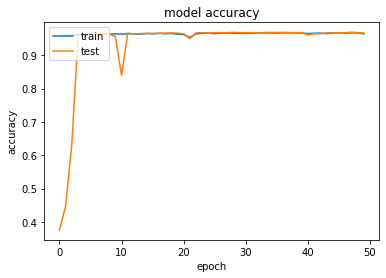

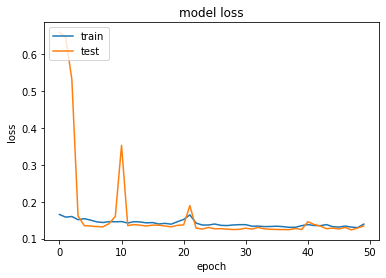

In [288]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It is normal for the loss to have some fluctuations in the beginning of the training process. This is because the model's weights are randomly initialized and the optimization algorithm is exploring the parameter space to find a good solution. As the optimization process continues, the model should converge to a better solution and the loss should decrease gradually.

However, if the fluctuations in the loss are very large and erratic, it could be an indication that the learning rate is too high or that the model architecture is not well-suited for the problem. In this case, it might be helpful to try reducing the learning rate or adjusting the model architecture to see if that improves the stability of the loss.

Overall, some fluctuations in the loss are expected in the beginning of the training process, but if the fluctuations are very large and unstable, it could be an indication that something is not working properly and further investigation is needed.

In [290]:
import tensorflow.keras.backend as K

def jaccard_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    jaccard_coef = (intersection + smooth) / (union + smooth)
    return 1 - jaccard_coef

# Register custom loss function with Keras
from keras.utils import custom_object_scope
with custom_object_scope({'jaccard_loss': jaccard_loss}):
    modelsgdjac_l = load_model('unet_sgdjac_l.h5')


preds_testsgdjac_l = modelsgdjac_l.predict(X_test, verbose=0)

IOU = iou_score(Y_test, preds_testsgdjac_l)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_testsgdjac_l)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_testsgdjac_l.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8752243380343766

Dice coefficient: 0.9229628

Precision: 0.9413657416543826
Recall: 0.9274946487084197
F1-score: 0.9343787180297349


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_func(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_func

# Compile the model with focal loss
model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])

#### Focal loss for Adam & SGD

In [96]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [99]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_func(y_true, y_pred):
        y_true = tf.cast(y_true, tf.bool)
        pt_1 = tf.where(y_true, y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(~y_true, y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_func

# Compile the model with focal loss
model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])

In [100]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_focal_ad.h5', verbose=1, save_best_only=True, monitor='val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9673
Epoch 1: val_loss improved from inf to 0.11074, saving model to unet_focal_ad.h5
31/31 [==============================] - 77s 2s/step - loss: 0.0527 - accuracy: 0.9673 - val_loss: 0.1107 - val_accuracy: 0.9468
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9633
Epoch 2: val_loss improved from 0.11074 to 0.06499, saving model to unet_focal_ad.h5
31/31 [==============================] - 70s 2s/step - loss: 0.0222 - accuracy: 0.9633 - val_loss: 0.0650 - val_accuracy: 0.9301
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9632
Epoch 3: val_loss improved from 0.06499 to 0.02280, saving model to unet_focal_ad.h5
31/31 [==============================] - 70s 2s/step - loss: 0.0158 - accuracy: 0.9632 - val_loss: 0.0228 - val_accuracy: 0.9609
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0146 - acc

31/31 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9653
Epoch 29: val_loss did not improve from 0.00802
31/31 [==============================] - 92s 3s/step - loss: 0.0087 - accuracy: 0.9653 - val_loss: 0.0085 - val_accuracy: 0.9634
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9580
Epoch 30: val_loss did not improve from 0.00802
31/31 [==============================] - 93s 3s/step - loss: 0.0097 - accuracy: 0.9580 - val_loss: 0.0085 - val_accuracy: 0.9652
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9659
Epoch 31: val_loss did not improve from 0.00802
31/31 [==============================] - 85s 3s/step - loss: 0.0086 - accuracy: 0.9659 - val_loss: 0.0086 - val_accuracy: 0.9659
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9672
Epoch 32: val_loss did not improve from 0.00802
31/31 [==============================] - 83s 3s/step 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


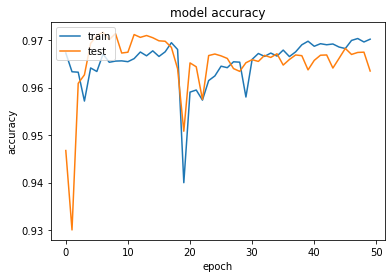

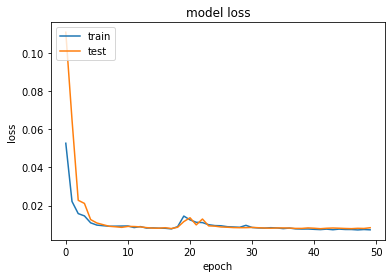

In [102]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_func(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_func

# Define a dictionary to map the custom function name to the function object
custom_objects = {'focal_loss_func': focal_loss()}

# Load the model using keras.utils.custom_object_scope
with tf.keras.utils.custom_object_scope(custom_objects):
    model_focal = tf.keras.models.load_model('unet_focal_ad.h5')

# Predict on the test set
preds_test_focal = model_focal.predict(X_test, verbose=0)


IOU = iou_score(Y_test, preds_test_focal)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_focal)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_focal.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.6929906403242765

Dice coefficient: 0.8004325

Precision: 0.9739533074512092
Recall: 0.8805605245449288
F1-score: 0.9249052991622994


In [292]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_focal_l.h5', verbose=1, save_best_only=True, monitor='val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9643
Epoch 1: val_loss improved from inf to 0.08463, saving model to unet_focal_l.h5
31/31 [==============================] - 90s 3s/step - loss: 0.1064 - accuracy: 0.9643 - val_loss: 0.0846 - val_accuracy: 0.9641
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9644
Epoch 2: val_loss improved from 0.08463 to 0.07349, saving model to unet_focal_l.h5
31/31 [==============================] - 77s 2s/step - loss: 0.0917 - accuracy: 0.9644 - val_loss: 0.0735 - val_accuracy: 0.9635
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9504
Epoch 3: val_loss did not improve from 0.07349
31/31 [==============================] - 76s 2s/step - loss: 0.0936 - accuracy: 0.9504 - val_loss: 0.1488 - val_accuracy: 0.8984
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9601
Epoch 4: val_loss improved

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


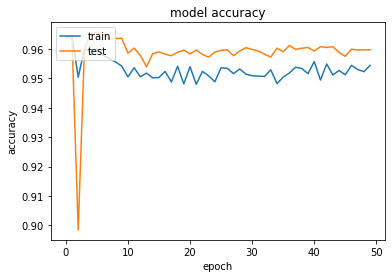

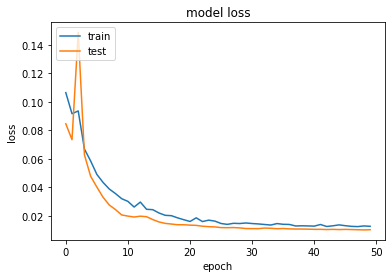

In [293]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [295]:
import tensorflow as tf
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_func(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_func

# Define a dictionary to map the custom function name to the function object
custom_objects = {'focal_loss_func': focal_loss()}

# Load the model using keras.utils.custom_object_scope
with tf.keras.utils.custom_object_scope(custom_objects):
    model_focal = tf.keras.models.load_model('unet_focal_l.h5')

# Predict on the test set
preds_test_focal = model_focal.predict(X_test, verbose=0)


IOU = iou_score(Y_test, preds_test_focal)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_focal)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_focal.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.6607797368888731

Dice coefficient: 0.7670877

Precision: 0.9712907471363221
Recall: 0.849737761350994
F1-score: 0.9064574456092886


### Activation function

Changing the activation function in a neural network can have a significant impact on the model's performance, and it is recommended to fine-tune the hyperparameters after changing the activation function.

While the loss function, learning rate, and batch size may be good for a specific activation function, they may not be optimal for another activation function. Therefore, it is generally a good practice to tune the hyperparameters again after changing the activation function to achieve the best performance.

That being said, we can use the previously optimized hyperparameters as a starting point and fine-tune them accordingly when changing the activation function. we can also consider using automated hyperparameter tuning techniques such as grid search, random search, or Bayesian optimization to efficiently explore the hyperparameter space and find the best configuration for our model with the new activation function.

In [296]:
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Lambda, BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (s)
c1 = LeakyReLU(alpha=0.1)(c1)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c1)
c1 = LeakyReLU(alpha=0.1)(c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (p1)
c2 = LeakyReLU(alpha=0.1)(c2)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c2)
c2 = LeakyReLU(alpha=0.1)(c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (p2)
c3 = LeakyReLU(alpha=0.1)(c3)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (c3)
c3 = LeakyReLU(alpha=0.1)(c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same') (p3)
c4 = LeakyReLU(alpha=0.1)(c4)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same') (c4)
c4 = LeakyReLU(alpha=0.1)(c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same') (p4)
c5 = LeakyReLU(alpha=0.1)(c5)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), kernel_initializer='he_normal', padding='same') (c5)
c5 = LeakyReLU(alpha=0.1)(c5)
c5 = BatchNormalization()(c5)

# Decoder
u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same') (u6)
c6 = LeakyReLU(alpha=0.1)(c6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same') (c6)
c6 = LeakyReLU(alpha=0.1)(c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (u7)
c7 = LeakyReLU(alpha=0.1)(c7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (c7)
c7 = LeakyReLU(alpha=0.1)(c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (u8)
c8 = LeakyReLU(alpha=0.1)(c8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c8)
c8 = LeakyReLU(alpha=0.1)(c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (u9)
c9 = LeakyReLU(alpha=0.1)(c9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c9)
c9 = LeakyReLU(alpha=0.1)(c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

The choice of activation function depends on the architecture of our neural network, the specific task of nuclei segmentation, and the type of data we are working with.

There are several activation functions that are commonly used in deep learning for segmentation tasks, including ReLU, LeakyReLU, ELU, and Sigmoid.

ReLU and its variants (LeakyReLU, ELU) are popular choices for segmentation tasks because they are computationally efficient and can help prevent the vanishing gradient problem. Sigmoid activation function can be used for binary segmentation tasks where the output should be a probability of whether a pixel belongs to a nucleus or not.

However, it's important to note that the choice of activation function is not the only factor that determines the performance of the model in nuclei segmentation. Other factors, such as the network architecture, loss function, learning rate, and data augmentation, can also have a significant impact on the model's performance.

It's recommended to try different activation functions and compare their performance on a validation set to determine the best choice for our specific task and data.

In [297]:
optimizer = SGD(lr=0.01, momentum=0.9)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint('unet_sgd_LR.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.8128
Epoch 1: val_loss improved from inf to 0.78496, saving model to unet_sgd_LR.h5
31/31 [==============================] - 104s 3s/step - loss: 0.4475 - accuracy: 0.8128 - val_loss: 0.7850 - val_accuracy: 0.2415
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.8962
Epoch 2: val_loss did not improve from 0.78496
31/31 [==============================] - 76s 2s/step - loss: 0.2782 - accuracy: 0.8962 - val_loss: 0.9815 - val_accuracy: 0.3355
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9160
Epoch 3: val_loss improved from 0.78496 to 0.58104, saving model to unet_sgd_LR.h5
31/31 [==============================] - 75s 2s/step - loss: 0.2215 - accuracy: 0.9160 - val_loss: 0.5810 - val_accuracy: 0.7807
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.1761 - accuracy: 0.9343
Epoch 4: val_loss improved 

Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9631
Epoch 30: val_loss did not improve from 0.08519
31/31 [==============================] - 78s 3s/step - loss: 0.0971 - accuracy: 0.9631 - val_loss: 0.0969 - val_accuracy: 0.9648
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9621
Epoch 31: val_loss did not improve from 0.08519
31/31 [==============================] - 78s 3s/step - loss: 0.0995 - accuracy: 0.9621 - val_loss: 0.0861 - val_accuracy: 0.9669
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9620
Epoch 32: val_loss improved from 0.08519 to 0.08230, saving model to unet_sgd_LR.h5
31/31 [==============================] - 78s 3s/step - loss: 0.1002 - accuracy: 0.9620 - val_loss: 0.0823 - val_accuracy: 0.9679
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9631
Epoch 33: val_loss did not improve from 0.08230
31/31

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


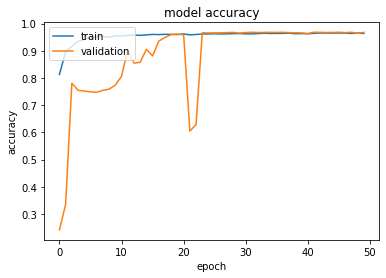

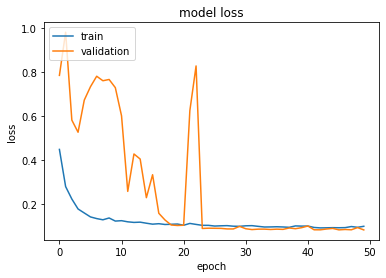

In [300]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [298]:
# Predict on test
model_sgd_LR = load_model('unet_sgd_LR.h5')
preds_test_sgd_LR = model_sgd_LR.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_sgd_LR)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_sgd_LR)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_sgd_LR.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8341332181941976

Dice coefficient: 0.8935602

Precision: 0.9228218697212838
Recall: 0.9458547356817021
F1-score: 0.9341963538718194


# U-Net ++
####  U-Net++ is a good model for nuclei segmentation. U-Net++ is an extension of the original U-Net architecture and has been shown to achieve state-of-the-art performance on various segmentation tasks, including nuclei segmentation.

One of the main advantages of U-Net++ over the original U-Net is that it incorporates a nested and dense skip pathway structure, which enables the model to capture multi-scale and context information better. This can be particularly helpful in segmentation tasks where the objects of interest have various sizes and shapes, such as nuclei segmentation.

Furthermore, U-Net++ has been shown to be effective with limited training data, which is often the case in medical image segmentation applications.

Overall, U-Net++ is a promising model for nuclei segmentation, and it has been shown to outperform other state-of-the-art segmentation models in various benchmarks and competitions.

In [159]:
# # import necessary packages
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
# from tensorflow.keras.models import Model

# Define the U-Net++ architecture
def unet_plusplus(input_shape=(128, 128, 3), num_classes=1):
    inputs = Input(input_shape)
    s = Lambda(lambda x: x / 255) (inputs)
    s1 = Conv2D(64, 3, activation='relu', padding='same')(s)
    s1 = Conv2D(64, 3, activation='relu', padding='same')(s1)
    p1 = MaxPooling2D(pool_size=2)(s1)

    s2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    s2 = Conv2D(128, 3, activation='relu', padding='same')(s2)
    p2 = MaxPooling2D(pool_size=2)(s2)

    s3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    s3 = Conv2D(256, 3, activation='relu', padding='same')(s3)
    p3 = MaxPooling2D(pool_size=2)(s3)

    s4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    s4 = Conv2D(512, 3, activation='relu', padding='same')(s4)
    p4 = MaxPooling2D(pool_size=2)(s4)

    center = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    center = Dropout(0.5)(center)
    center = Conv2D(1024, 3, activation='relu', padding='same')(center)
    center = Dropout(0.5)(center)
    
    u4 = UpSampling2D(size=(2, 2), interpolation='bilinear')(center)
    u4 = concatenate([s4, u4], axis=3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(u4)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)

    u3 = UpSampling2D(size=(2, 2), interpolation='bilinear')(c4)
    u3 = concatenate([s3, u3], axis=3)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(u3)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)

    u2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(c3)
    u2 = concatenate([s2, u2], axis=3)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(u2)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)

    u1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(c2)
    u1 = concatenate([s1, u1], axis=3)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)

    outputs = Conv2D(num_classes, 1, activation='sigmoid')(c1)

    # Define the model
    model = Model(inputs, outputs)

    return model


Dice loss is commonly used as the loss function for image segmentation tasks with U-Net models, including U-Net++. It is effective in handling class imbalance, which is a common issue in segmentation tasks, and is also known to produce sharper segmentation boundaries compared to other loss functions like binary cross-entropy.

However, it's worth noting that the optimal loss function for a particular task depends on the specifics of the data and the problem at hand. It's always a good idea to try out different loss functions and compare their performance on a validation set to determine which one works best for our specific task.

In [180]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    numerator = 2 * K.sum(y_true * y_pred, axis=(1,2,3))
    denominator = K.sum(K.square(y_true) + K.square(y_pred), axis=(1,2,3))
    return K.mean(numerator / denominator)

def dice_coeff(y_true, y_pred):
    numerator = 2 * K.sum(y_true * y_pred, axis=(1,2,3))
    denominator = K.sum(y_true + y_pred, axis=(1,2,3))
    return K.mean(numerator / denominator)

Yes, Dice coefficient is a more appropriate metric than accuracy for nuclei segmentation task because accuracy is not well-suited to handle class imbalance, which is common in segmentation tasks where the object of interest is small compared to the background. In the case of nuclei segmentation, the foreground (nuclei) is often much smaller in area compared to the background, which means accuracy can be misleading as it might indicate high accuracy even when the model is not accurately segmenting the nuclei.

On the other hand, Dice coefficient is a measure of overlap between predicted and ground truth masks, and it handles class imbalance well. It is sensitive to both false positives and false negatives, and it is widely used in segmentation tasks. Therefore, using Dice coefficient as the evaluation metric for nuclei segmentation is more appropriate than accuracy.

In [177]:
# Define the input shape and number of classes
from keras.metrics import accuracy

input_shape = (128, 128, 3)
num_classes = 1

# Create an instance of the U-Net++ model
model_unet_plusplus = unet_plusplus(input_shape=input_shape, num_classes=num_classes)

# Compile the model with an optimizer, loss function, and metric(s)
optimizer = Adam(learning_rate=1e-4)
loss_fn = dice_loss
# metrics = [dice_coeff]
metrics = [accuracy]
model_unet_plusplus.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [178]:
checkpointer = ModelCheckpoint('unet_pp_1.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model_unet_plusplus.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.3076
Epoch 1: val_loss improved from inf to 0.00000, saving model to unet_pp_1.h5
31/31 [==============================] - 219s 7s/step - loss: 0.1903 - accuracy: 0.3076 - val_loss: 0.0000e+00 - val_accuracy: 0.7251
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7608
Epoch 2: val_loss did not improve from 0.00000
31/31 [==============================] - 223s 7s/step - loss: 0.0000e+00 - accuracy: 0.7608 - val_loss: 0.0000e+00 - val_accuracy: 0.7251
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7608
Epoch 3: val_loss did not improve from 0.00000
31/31 [==============================] - 225s 7s/step - loss: 0.0000e+00 - accuracy: 0.7608 - val_loss: 0.0000e+00 - val_accuracy: 0.7251
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7608
Epoch 4: val_loss did not impro

Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7608
Epoch 30: val_loss did not improve from 0.00000
31/31 [==============================] - 254s 8s/step - loss: 0.0000e+00 - accuracy: 0.7608 - val_loss: 0.0000e+00 - val_accuracy: 0.7251
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7608
Epoch 31: val_loss did not improve from 0.00000
31/31 [==============================] - 253s 8s/step - loss: 0.0000e+00 - accuracy: 0.7608 - val_loss: 0.0000e+00 - val_accuracy: 0.7251
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7608
Epoch 32: val_loss did not improve from 0.00000
31/31 [==============================] - 253s 8s/step - loss: 0.0000e+00 - accuracy: 0.7608 - val_loss: 0.0000e+00 - val_accuracy: 0.7251
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.7608
Epoch 33: val_loss did not improve from 0.0000

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


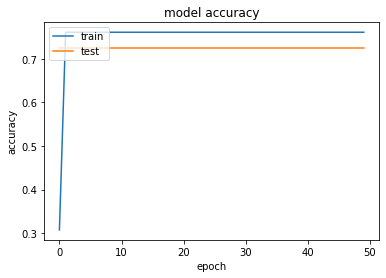

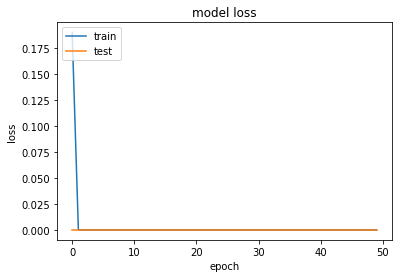

In [184]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [182]:
# Load the saved model and make predictions on test data
from keras.models import load_model
model_pp_1 = load_model('unet_pp_1.h5', custom_objects={'dice_loss': dice_loss})
preds_test_pp_1 = model_pp_1.predict(X_test, verbose=0)

In [183]:
IOU = iou_score(Y_test, preds_test_pp_1)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_pp_1)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1pp_flat = preds_test_pp_1.reshape(-1)

# Convert predictions to binary values
y_pred_1pp_flat_binary = y_pred_1pp_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1pp_flat_binary)
recall = recall_score(y_true_flat, y_pred_1pp_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1pp_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.0

Dice coefficient: 1.6907686e-06


/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Precision: 0.0
Recall: 0.0
F1-score: 0.0


____________________________________________________________________________________________________________________
If the loss has reached zero during training, it could mean that the model has completely memorized the training data and is overfitting. In other words, the model has learned to perfectly fit the training data and is not able to generalize to new, unseen data. This can result in poor performance on the test set, since the model is not able to generalize to new data.

It's worth noting that sometimes a very low loss value during training can be a good sign, especially if it is consistent with good performance on the validation and test sets. However, if the loss has reached exactly zero during training, it is almost certainly a sign of overfitting or a bug in the code.

The IOU score, Dice coefficient, precision, recall, and F1-score metrics all indicate poor performance of the model. The IOU score and Dice coefficient are close to 0, indicating that the predicted masks have very little overlap with the ground truth masks. The precision and recall are both 0, indicating that the model did not make any true positive predictions. The F1-score is also 0, which is the harmonic mean of precision and recall, indicating poor overall performance.

This suggests that the model needs to be improved, either by adjusting the architecture, the hyperparameters, or the training process. It may also be necessary to consider using a larger dataset or incorporating other forms of data augmentation to improve the model's ability to generalize to new data.
____________________________________________________________________________________________________________________

## Different U-Net architecture

The U-Net architecture we provided is quite different from the one we provided earlier. The U-Net architecture is used for image segmentation problems and has an encoder-decoder architecture that uses skip connections to concatenate feature maps from the encoder to the decoder. The U-Net architecture we provided has the following components:

- The input layer: The input layer takes an input image of shape (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS).

- The contracting or encoder path: The encoder path consists of a series of convolutional layers with max pooling layers in between. Each convolutional layer applies a filter on the input image, and a max pooling layer reduces the spatial dimensions of the output of each convolutional layer.

- The expansive or decoder path: The decoder path consists of a series of transposed convolutional layers with concatenation of feature maps from the encoder path. Each transposed convolutional layer upsamples the output of the previous layer and concatenates it with the corresponding feature map from the encoder path. The concatenated feature maps are then passed through a series of convolutional layers to produce the final output.

- Skip connections: Skip connections are used to concatenate feature maps from the encoder to the decoder path. The skip connections provide a direct path for the gradient to flow from the decoder to the encoder path, allowing the model to better segment objects in the image.

- Batch normalization: Batch normalization is used after each convolutional layer to speed up training and improve the generalization of the model.

- Dropout regularization: Dropout is used to regularize the model and prevent overfitting.

- Dilation: Dilation is used in some of the convolutional layers to increase the receptive field of the filters and improve the performance of the model.

Overall, the U-Net architecture we provided is more complex and has more layers than the one we provided earlier. It also uses skip connections and batch normalization, which are not used in the architecture we provided earlier.

In [66]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

# use dilated convolutions
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2,2)) (c5)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)

# add skip connection from earlier layers
p3_1 = Conv2D(256, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c6 = concatenate([UpSampling2D(size=(2, 2)) (c5), p3_1], axis=-1)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

# use dilated convolutions
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2,2)) (c6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)

# add skip connection from earlier layers
p2_1 = Conv2D(128, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c7 = concatenate([UpSampling2D(size=(2, 2)) (c6), p2_1], axis=-1)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

# use dilated convolutions
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=(2,2)) (c7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)

# add skip connection from earlier layers
p1_1 = Conv2D(64, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c8 = concatenate([UpSampling2D(size=(2, 2)) (c7), p1_1], axis=-1)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.2)(c8)
c8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(c8)
c8 = BatchNormalization()(c8)

u9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c7))
u9 = concatenate([c2, u9], axis = 3)
c9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.2)(c9)
c9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(c9)
c9 = BatchNormalization()(c9)

u10 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(c9))
u10 = concatenate([c1, u10], axis = 3)
c10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u10)
c10 = BatchNormalization()(c10)
c10 = Dropout(0.2)(c10)
c10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(c10)
c10 = BatchNormalization()(c10)

outputs = Conv2D(1, 1, activation = 'sigmoid')(c10)

model = Model(inputs = [inputs], outputs = [outputs])

Although both architectures follow the same basic structure of U-Net, the number of convolutional layers and the number of filters used in each layer are different. Additionally, this architecture includes dilated convolutions, which allows the network to have a larger receptive field without having to use very deep networks. This architecture also includes skip connections that help the network to recover the spatial information of the image. Overall, this architecture is designed to be deeper and more complex, which may improve its performance in certain applications.

In [258]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_22 (Lambda)             (None, 128, 128, 3)  0           ['input_26[0][0]']               
                                                                                                  
 conv2d_409 (Conv2D)            (None, 128, 128, 32  896         ['lambda_22[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_419 (Conv2D)            (None, 8, 8, 512)    2359808     ['batch_normalization_142[0][0]']
                                                                                                  
 batch_normalization_143 (Batch  (None, 8, 8, 512)   2048        ['conv2d_419[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 dropout_123 (Dropout)          (None, 8, 8, 512)    0           ['batch_normalization_143[0][0]']
                                                                                                  
 up_sampling2d_58 (UpSampling2D  (None, 16, 16, 512)  0          ['dropout_123[0][0]']            
 )                                                                                                
                                                                                                  
 conv2d_42

                                                                                                  
 conv2d_434 (Conv2D)            (None, 128, 128, 32  8224        ['up_sampling2d_62[0][0]']       
                                )                                                                 
                                                                                                  
 concatenate_78 (Concatenate)   (None, 128, 128, 64  0           ['batch_normalization_134[0][0]',
                                )                                 'conv2d_434[0][0]']             
                                                                                                  
 conv2d_435 (Conv2D)            (None, 128, 128, 32  18464       ['concatenate_78[0][0]']         
                                )                                                                 
                                                                                                  
 batch_nor

In [152]:
# Fit model
# earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint('unet_new_1.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8746
Epoch 1: val_loss improved from inf to 48.30931, saving model to unet_new_1.h5
31/31 [==============================] - 104s 3s/step - loss: 0.3574 - accuracy: 0.8746 - val_loss: 48.3093 - val_accuracy: 0.2784
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9326
Epoch 2: val_loss did not improve from 48.30931
31/31 [==============================] - 99s 3s/step - loss: 0.2137 - accuracy: 0.9326 - val_loss: 64.4424 - val_accuracy: 0.2770
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.9469
Epoch 3: val_loss improved from 48.30931 to 1.01811, saving model to unet_new_1.h5
31/31 [==============================] - 104s 3s/step - loss: 0.1667 - accuracy: 0.9469 - val_loss: 1.0181 - val_accuracy: 0.7252
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9541
Epoch 4: val_loss impro

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


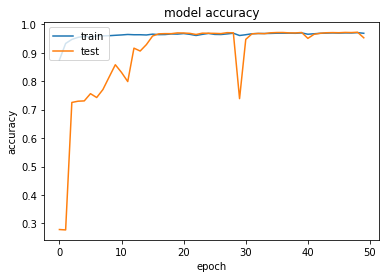

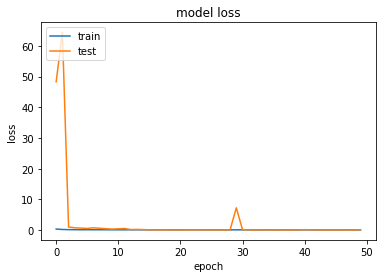

In [153]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [154]:
# Predict on test
model_new_1 = load_model('unet_new_1.h5')
preds_test_new1 = model_new_1.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_new1)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_new1)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_1_flat = preds_test_new1.reshape(-1)

# Convert predictions to binary values
y_pred_1_flat_binary = y_pred_1_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_1_flat_binary)
recall = recall_score(y_true_flat, y_pred_1_flat_binary)
f1 = f1_score(y_true_flat, y_pred_1_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8401790781114022

Dice coefficient: 0.9131492

Precision: 0.9302465443912812
Recall: 0.9467204106545652
F1-score: 0.9384111831575561


In [155]:
checkpointer = ModelCheckpoint('unet_new_2.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9686
Epoch 1: val_loss improved from inf to 0.10318, saving model to unet_new_2.h5
16/16 [==============================] - 99s 6s/step - loss: 0.0826 - accuracy: 0.9686 - val_loss: 0.1032 - val_accuracy: 0.9568
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9706
Epoch 2: val_loss improved from 0.10318 to 0.07565, saving model to unet_new_2.h5
16/16 [==============================] - 111s 7s/step - loss: 0.0744 - accuracy: 0.9706 - val_loss: 0.0757 - val_accuracy: 0.9699
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9710
Epoch 3: val_loss improved from 0.07565 to 0.07533, saving model to unet_new_2.h5
16/16 [==============================] - 109s 7s/step - loss: 0.0736 - accuracy: 0.9710 - val_loss: 0.0753 - val_accuracy: 0.9709
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


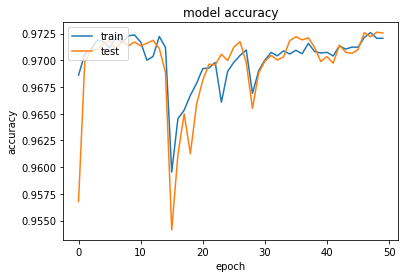

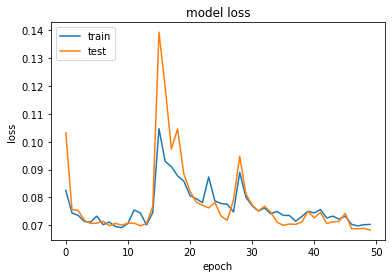

In [156]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [157]:
# Predict on test
model_new_2 = load_model('unet_new_2.h5')
preds_test_new2 = model_new_2.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_new2)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_new2)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_new2.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8487473621447162

Dice coefficient: 0.91818637

Precision: 0.9337382486883805
Recall: 0.9484805037146249
F1-score: 0.941051642719945


In [259]:
checkpointer = ModelCheckpoint('unet_new_3.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.8633
Epoch 1: val_loss improved from inf to 28.88389, saving model to unet_new_3.h5
61/61 [==============================] - 125s 2s/step - loss: 0.3696 - accuracy: 0.8633 - val_loss: 28.8839 - val_accuracy: 0.2811
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9225
Epoch 2: val_loss improved from 28.88389 to 1.38084, saving model to unet_new_3.h5
61/61 [==============================] - 110s 2s/step - loss: 0.2341 - accuracy: 0.9225 - val_loss: 1.3808 - val_accuracy: 0.7327
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9380
Epoch 3: val_loss improved from 1.38084 to 0.80788, saving model to unet_new_3.h5
61/61 [==============================] - 112s 2s/step - loss: 0.1833 - accuracy: 0.9380 - val_loss: 0.8079 - val_accuracy: 0.7402
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 0.1511 - accura

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


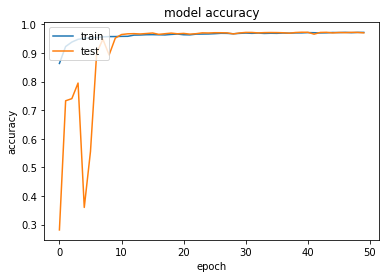

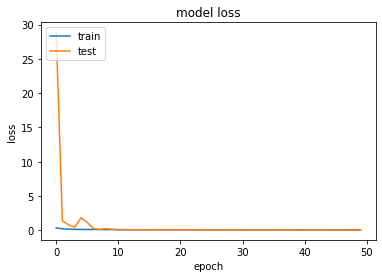

In [260]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [261]:
model_new_2 = load_model('unet_new_3.h5')
preds_test_new2 = model_new_2.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_new2)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_new2)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_new2.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8451395727846522

Dice coefficient: 0.9034783

Precision: 0.9413652201403528
Recall: 0.9414654930458571
F1-score: 0.9414153539230149


In [262]:
checkpointer = ModelCheckpoint('unet_new_4.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=4, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
121/121 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9614
Epoch 1: val_loss improved from inf to 0.12857, saving model to unet_new_4.h5
121/121 [==============================] - 130s 1s/step - loss: 0.1045 - accuracy: 0.9614 - val_loss: 0.1286 - val_accuracy: 0.9502
Epoch 2/50
121/121 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9607
Epoch 2: val_loss improved from 0.12857 to 0.09570, saving model to unet_new_4.h5
121/121 [==============================] - 122s 1s/step - loss: 0.1061 - accuracy: 0.9607 - val_loss: 0.0957 - val_accuracy: 0.9675
Epoch 3/50
121/121 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9672
Epoch 3: val_loss improved from 0.09570 to 0.08844, saving model to unet_new_4.h5
121/121 [==============================] - 122s 1s/step - loss: 0.0858 - accuracy: 0.9672 - val_loss: 0.0884 - val_accuracy: 0.9695
Epoch 4/50
121/121 [==============================] - ETA: 0s - loss: 0.08

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


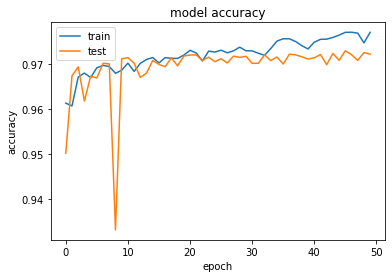

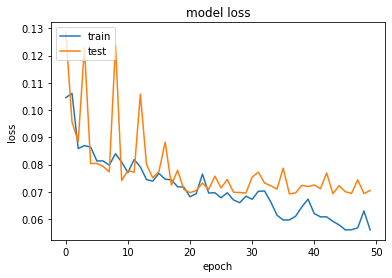

In [263]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [264]:
model_new_4 = load_model('unet_new_4.h5')
preds_test_new4 = model_new_4.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_new4)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_new4)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_new4.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8555351604173898

Dice coefficient: 0.90869266

Precision: 0.938059872259949
Recall: 0.9426371976477987
F1-score: 0.9403429647033426


In [265]:
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_22 (Lambda)             (None, 128, 128, 3)  0           ['input_26[0][0]']               
                                                                                                  
 conv2d_409 (Conv2D)            (None, 128, 128, 32  896         ['lambda_22[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_419 (Conv2D)            (None, 8, 8, 512)    2359808     ['batch_normalization_142[0][0]']
                                                                                                  
 batch_normalization_143 (Batch  (None, 8, 8, 512)   2048        ['conv2d_419[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 dropout_123 (Dropout)          (None, 8, 8, 512)    0           ['batch_normalization_143[0][0]']
                                                                                                  
 up_sampling2d_58 (UpSampling2D  (None, 16, 16, 512)  0          ['dropout_123[0][0]']            
 )                                                                                                
                                                                                                  
 conv2d_42

                                                                                                  
 conv2d_434 (Conv2D)            (None, 128, 128, 32  8224        ['up_sampling2d_62[0][0]']       
                                )                                                                 
                                                                                                  
 concatenate_78 (Concatenate)   (None, 128, 128, 64  0           ['batch_normalization_134[0][0]',
                                )                                 'conv2d_434[0][0]']             
                                                                                                  
 conv2d_435 (Conv2D)            (None, 128, 128, 32  18464       ['concatenate_78[0][0]']         
                                )                                                                 
                                                                                                  
 batch_nor

In [266]:
checkpointer = ModelCheckpoint('unet_new_5.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9505
Epoch 1: val_loss improved from inf to 1489.14563, saving model to unet_new_5.h5
61/61 [==============================] - 129s 2s/step - loss: 0.1326 - accuracy: 0.9505 - val_loss: 1489.1456 - val_accuracy: 0.2830
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9576
Epoch 2: val_loss improved from 1489.14563 to 33.77122, saving model to unet_new_5.h5
61/61 [==============================] - 118s 2s/step - loss: 0.1105 - accuracy: 0.9576 - val_loss: 33.7712 - val_accuracy: 0.5249
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9616
Epoch 3: val_loss improved from 33.77122 to 1.58403, saving model to unet_new_5.h5
61/61 [==============================] - 103s 2s/step - loss: 0.1031 - accuracy: 0.9616 - val_loss: 1.5840 - val_accuracy: 0.8541
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 0.1156

Epoch 30/50
61/61 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9703
Epoch 30: val_loss did not improve from 0.07144
61/61 [==============================] - 261s 4s/step - loss: 0.0767 - accuracy: 0.9703 - val_loss: 0.0768 - val_accuracy: 0.9695
Epoch 31/50
61/61 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9712
Epoch 31: val_loss did not improve from 0.07144
61/61 [==============================] - 109s 2s/step - loss: 0.0748 - accuracy: 0.9712 - val_loss: 0.0744 - val_accuracy: 0.9699
Epoch 32/50
61/61 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9718
Epoch 32: val_loss did not improve from 0.07144
61/61 [==============================] - 109s 2s/step - loss: 0.0711 - accuracy: 0.9718 - val_loss: 0.0780 - val_accuracy: 0.9684
Epoch 33/50
61/61 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 0.9722
Epoch 33: val_loss did not improve from 0.07144
61/61 [==============================]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


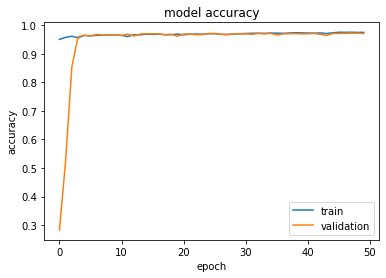

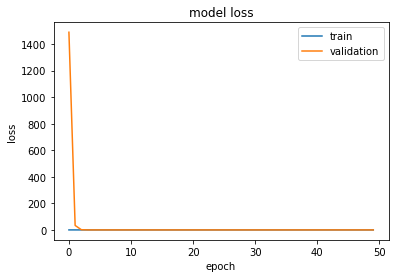

In [273]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [268]:
model_new_5 = load_model('unet_new_5.h5')
preds_test_new5 = model_new_5.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_new5)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_new5)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_new5.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8485689238268643

Dice coefficient: 0.9038114

Precision: 0.9395910593017855
Recall: 0.9441504380788779
F1-score: 0.9418652309654045


In [274]:
checkpointer = ModelCheckpoint('unet_new_5.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9775
Epoch 1: val_loss improved from inf to 0.06682, saving model to unet_new_5.h5
31/31 [==============================] - 101s 3s/step - loss: 0.0555 - accuracy: 0.9775 - val_loss: 0.0668 - val_accuracy: 0.9734
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9777
Epoch 2: val_loss did not improve from 0.06682
31/31 [==============================] - 110s 4s/step - loss: 0.0545 - accuracy: 0.9777 - val_loss: 0.0673 - val_accuracy: 0.9731
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9757
Epoch 3: val_loss did not improve from 0.06682
31/31 [==============================] - 107s 3s/step - loss: 0.0594 - accuracy: 0.9757 - val_loss: 0.0727 - val_accuracy: 0.9714
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9778
Epoch 4: val_loss did not improve from 0.06682
31/31 [========

Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9810
Epoch 31: val_loss did not improve from 0.06682
31/31 [==============================] - 100s 3s/step - loss: 0.0461 - accuracy: 0.9810 - val_loss: 0.0721 - val_accuracy: 0.9721
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9817
Epoch 32: val_loss did not improve from 0.06682
31/31 [==============================] - 100s 3s/step - loss: 0.0444 - accuracy: 0.9817 - val_loss: 0.0738 - val_accuracy: 0.9726
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9819
Epoch 33: val_loss did not improve from 0.06682
31/31 [==============================] - 100s 3s/step - loss: 0.0438 - accuracy: 0.9819 - val_loss: 0.0773 - val_accuracy: 0.9715
Epoch 34/50
31/31 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9821
Epoch 34: val_loss did not improve from 0.06682
31/31 [==============================]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


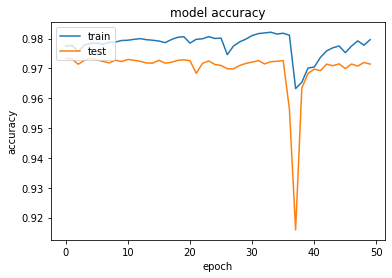

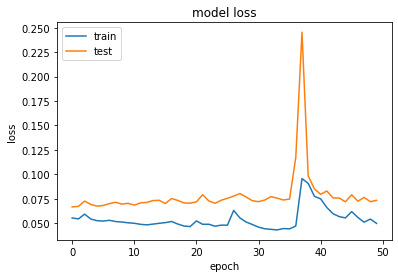

In [275]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [277]:
model_new_6 = load_model('unet_new_5.h5')
preds_test_new6 = model_new_6.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_new6)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_new6)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_new6.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.858174672669303

Dice coefficient: 0.9107649

Precision: 0.9366398030595158
Recall: 0.9495084927448998
F1-score: 0.9430302480734968


In [302]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_26 (Lambda)             (None, 128, 128, 3)  0           ['input_30[0][0]']               
                                                                                                  
 conv2d_495 (Conv2D)            (None, 128, 128, 32  896         ['lambda_26[0][0]']              
                                )                                                                 
                                                                                           

 conv2d_505 (Conv2D)            (None, 8, 8, 512)    2359808     ['batch_normalization_219[0][0]']
                                                                                                  
 batch_normalization_220 (Batch  (None, 8, 8, 512)   2048        ['conv2d_505[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 dropout_163 (Dropout)          (None, 8, 8, 512)    0           ['batch_normalization_220[0][0]']
                                                                                                  
 up_sampling2d_63 (UpSampling2D  (None, 16, 16, 512)  0          ['dropout_163[0][0]']            
 )                                                                                                
                                                                                                  
 conv2d_50

                                                                                                  
 conv2d_520 (Conv2D)            (None, 128, 128, 32  8224        ['up_sampling2d_67[0][0]']       
                                )                                                                 
                                                                                                  
 concatenate_95 (Concatenate)   (None, 128, 128, 64  0           ['batch_normalization_211[0][0]',
                                )                                 'conv2d_520[0][0]']             
                                                                                                  
 conv2d_521 (Conv2D)            (None, 128, 128, 32  18464       ['concatenate_95[0][0]']         
                                )                                                                 
                                                                                                  
 batch_nor

In [303]:
checkpointer = ModelCheckpoint('unet_new_7.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.6191
Epoch 1: val_loss improved from inf to 0.89788, saving model to unet_new_7.h5
61/61 [==============================] - 118s 2s/step - loss: 0.6899 - accuracy: 0.6191 - val_loss: 0.8979 - val_accuracy: 0.3300
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.8167
Epoch 2: val_loss improved from 0.89788 to 0.57790, saving model to unet_new_7.h5
61/61 [==============================] - 116s 2s/step - loss: 0.4490 - accuracy: 0.8167 - val_loss: 0.5779 - val_accuracy: 0.7152
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8804
Epoch 3: val_loss improved from 0.57790 to 0.52865, saving model to unet_new_7.h5
61/61 [==============================] - 121s 2s/step - loss: 0.3548 - accuracy: 0.8804 - val_loss: 0.5286 - val_accuracy: 0.7473
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 0.2951 - accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


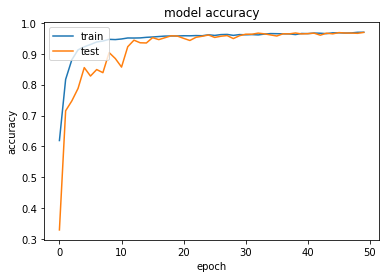

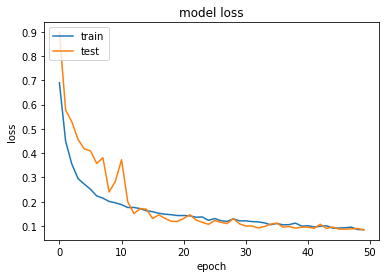

In [304]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [305]:
model_new_7 = load_model('unet_new_7.h5')
preds_test_new_7 = model_new_7.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_new_7)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_new_7)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_new_7.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8195149578074598

Dice coefficient: 0.87310153

Precision: 0.9360953154616842
Recall: 0.9176645036064155
F1-score: 0.9267882863307226


In [306]:
#BEST SGD model for U-Net 1
optimizer = SGD(lr=0.01, momentum=0.9)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint('unet__new_sgd_1.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50


/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


31/31 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9712
Epoch 1: val_loss improved from inf to 0.09599, saving model to unet__new_sgd_1.h5
31/31 [==============================] - 103s 3s/step - loss: 0.0777 - accuracy: 0.9712 - val_loss: 0.0960 - val_accuracy: 0.9650
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9696
Epoch 2: val_loss did not improve from 0.09599
31/31 [==============================] - 95s 3s/step - loss: 0.0810 - accuracy: 0.9696 - val_loss: 0.1084 - val_accuracy: 0.9607
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9681
Epoch 3: val_loss did not improve from 0.09599
31/31 [==============================] - 256s 3s/step - loss: 0.0839 - accuracy: 0.9681 - val_loss: 0.1100 - val_accuracy: 0.9598
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9666
Epoch 4: val_loss did not improve from 0.09599
31/31 [===============

Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9706
Epoch 31: val_loss did not improve from 0.08541
31/31 [==============================] - 116s 4s/step - loss: 0.0744 - accuracy: 0.9706 - val_loss: 0.1026 - val_accuracy: 0.9650
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9716
Epoch 32: val_loss did not improve from 0.08541
31/31 [==============================] - 116s 4s/step - loss: 0.0723 - accuracy: 0.9716 - val_loss: 0.0930 - val_accuracy: 0.9674
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9723
Epoch 33: val_loss did not improve from 0.08541
31/31 [==============================] - 117s 4s/step - loss: 0.0702 - accuracy: 0.9723 - val_loss: 0.0900 - val_accuracy: 0.9683
Epoch 34/50
31/31 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9717
Epoch 34: val_loss did not improve from 0.08541
31/31 [==============================]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


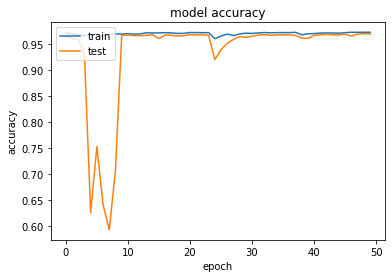

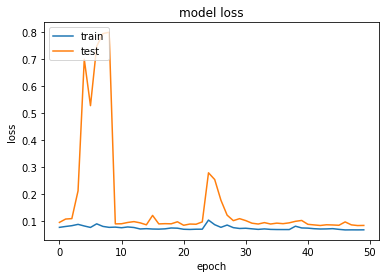

In [307]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [309]:
model_new_sgd_1 = load_model('unet__new_sgd_1.h5')
preds_test_new_sgd_1 = model_new_sgd_1.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_new_sgd_1)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_new_sgd_1)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_new_sgd_1.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8461984693137751

Dice coefficient: 0.906324

Precision: 0.9358193935094754
Recall: 0.9323589981164806
F1-score: 0.9340859909969044


In [310]:
optimizer = SGD(lr=0.01, momentum=0.9)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint('unet__new_sgd_1.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50


/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


61/61 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9713
Epoch 1: val_loss improved from inf to 0.09097, saving model to unet__new_sgd_1.h5
61/61 [==============================] - 110s 2s/step - loss: 0.0726 - accuracy: 0.9713 - val_loss: 0.0910 - val_accuracy: 0.9679
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9719
Epoch 2: val_loss improved from 0.09097 to 0.08960, saving model to unet__new_sgd_1.h5
61/61 [==============================] - 100s 2s/step - loss: 0.0711 - accuracy: 0.9719 - val_loss: 0.0896 - val_accuracy: 0.9677
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 0.0698 - accuracy: 0.9724
Epoch 3: val_loss improved from 0.08960 to 0.08749, saving model to unet__new_sgd_1.h5
61/61 [==============================] - 101s 2s/step - loss: 0.0698 - accuracy: 0.9724 - val_loss: 0.0875 - val_accuracy: 0.9691
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 0.0700 - accur

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


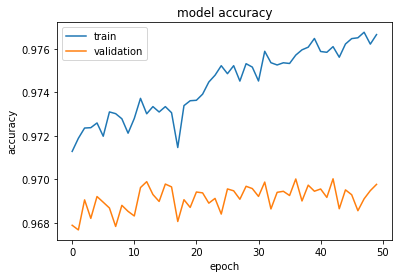

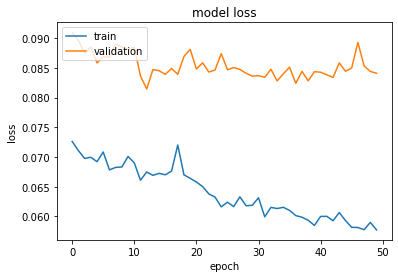

In [313]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [312]:
model_new_sgd_1 = load_model('unet__new_sgd_1.h5')
preds_test_new_sgd_1 = model_new_sgd_1.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_new_sgd_1)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_new_sgd_1)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_new_sgd_1.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.8459684366260295

Dice coefficient: 0.9047082

Precision: 0.9260897209232062
Recall: 0.9432086783916029
F1-score: 0.9345708123049861


In [67]:
optimizer = SGD(lr=0.001, momentum=0.9)
# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint('unet_new_sgd_2.h5', verbose=1, save_best_only=True, monitor = 'val_loss')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[checkpointer])

Epoch 1/50


/Users/xeniat/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


31/31 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.6139
Epoch 1: val_loss improved from inf to 0.71041, saving model to unet_new_sgd_2.h5
31/31 [==============================] - 102s 3s/step - loss: 0.7581 - accuracy: 0.6139 - val_loss: 0.7104 - val_accuracy: 0.3324
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.7726
Epoch 2: val_loss did not improve from 0.71041
31/31 [==============================] - 101s 3s/step - loss: 0.5101 - accuracy: 0.7726 - val_loss: 0.7671 - val_accuracy: 0.3049
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.8461
Epoch 3: val_loss did not improve from 0.71041
31/31 [==============================] - 108s 3s/step - loss: 0.4036 - accuracy: 0.8461 - val_loss: 1.0050 - val_accuracy: 0.2854
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.8690
Epoch 4: val_loss did not improve from 0.71041
31/31 [===============

31/31 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9462
Epoch 30: val_loss did not improve from 0.11913
31/31 [==============================] - 99s 3s/step - loss: 0.1494 - accuracy: 0.9462 - val_loss: 0.1584 - val_accuracy: 0.9427
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9489
Epoch 31: val_loss did not improve from 0.11913
31/31 [==============================] - 101s 3s/step - loss: 0.1429 - accuracy: 0.9489 - val_loss: 0.1248 - val_accuracy: 0.9541
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9501
Epoch 32: val_loss did not improve from 0.11913
31/31 [==============================] - 102s 3s/step - loss: 0.1391 - accuracy: 0.9501 - val_loss: 0.1404 - val_accuracy: 0.9492
Epoch 33/50
31/31 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9499
Epoch 33: val_loss improved from 0.11913 to 0.11614, saving model to unet_new_sgd_2.h5
31/31 [=====

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


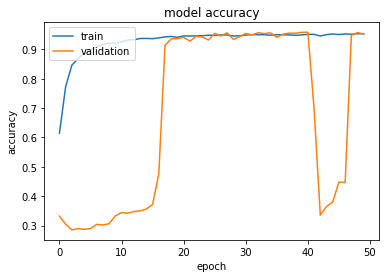

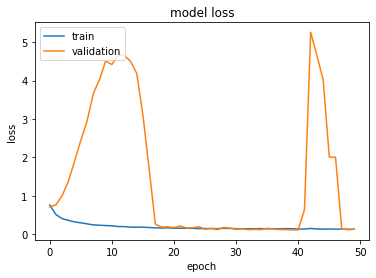

In [68]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [69]:
model_new_sgd_2 = load_model('unet_new_sgd_2.h5')
preds_test_new_sgd_2 = model_new_sgd_2.predict(X_test, verbose=0)

# Performance metrics
IOU = iou_score(Y_test, preds_test_new_sgd_2)
print("IOU score:", IOU)
dice = dice_coef(Y_test, preds_test_new_sgd_2)
print("\nDice coefficient:", dice.numpy())
# Flatten the predictions and ground truth masks
y_true_flat = Y_test.reshape(-1)
y_pred_2_flat = preds_test_new_sgd_2.reshape(-1)

# Convert predictions to binary values
y_pred_2_flat_binary = y_pred_2_flat > 0.5

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_flat, y_pred_2_flat_binary)
recall = recall_score(y_true_flat, y_pred_2_flat_binary)
f1 = f1_score(y_true_flat, y_pred_2_flat_binary)

# Print the metrics for the test set
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

IOU score: 0.7868166315344317

Dice coefficient: 0.88069075

Precision: 0.9033628070970202
Recall: 0.9170710428340034
F1-score: 0.9101653120692157
